# This notebook describes the script created for the analysis. For the insights and full data analysis, please check the ewas_report.pdf. Relevant dataset should be inside the same directory with this file for the notebook to execute properly.

# To run the script, you can click Run without doing anything. Plots will be automatically opened if an IDE with a plots pane is used. Maps should be opened on the default browser. Execution times takes approximately 40 seconds.

First, we import the required libraries for the analysis.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import webbrowser
import folium
import tzlocal
import seaborn as sns
import random
from datetime import datetime

We transform unix-timestamps to Python datetime objects with local time zones.

In [2]:
local_timezone = tzlocal.get_localzone() # get pytz timezone


def time_localizer(ts_array): # transforms timestamps to local times
    local_times = np.array([])
    
    for x in ts_array:
        unix_timestamp = float(x)

        local_time = datetime.fromtimestamp(unix_timestamp, local_timezone)
        local_times = np.append(local_times, local_time)
        
    return local_times

We create the function create_riskplot to plot desired data for each combination of area scale (district or neighbourhood)
and risk type.

In [3]:
def create_riskplot(scale, risk_type):
    
    if scale == 'ilce':
        x_label = 'District'
        if risk_type == 'Yagis_Risk':
            dataFrame = df_avgPrec
            y_label = 'Precipitation Risk' 
            title = 'Precipitation Risk by Each District'

        elif risk_type == 'Buzlanma_Risk':
            dataFrame = df_avgIcy
            y_label = 'Icy Road Risk' 
            title = 'Icy Road Risk by Each District'

        elif risk_type == 'Ruzgar_Risk':
            dataFrame = df_avgWind
            y_label = 'Wind Risk' 
            title = 'Wind Risk by Each District'

        else:
            raise Exception('Risk type not valid!')
            
    elif scale == 'Mahalle':
        x_label = 'Neighbourhood'
        if risk_type == 'Yagis_Risk':
            dataFrame = df_nbhPrec
            y_label = 'Precipitation Risk' 
            title = 'Precipitation Risk by Each Neighbourhood'

       
        elif risk_type == 'Buzlanma_Risk':
            dataFrame = df_nbhIcy
            y_label = 'Icy Road Risk' 
            title = 'Icy Road Risk by Each Neighbourhood'


        elif risk_type == 'Ruzgar_Risk':
            dataFrame = df_nbhWind
            y_label = 'Wind Risk' 
            title = 'Wind Risk by Each Neighbourhood'

        else:
            raise Exception('Risk type not valid!')
        
    plt.rcParams["figure.dpi"] = 1000
    sns.scatterplot(data=dataFrame.iloc[:10], x= scale, y= risk_type, c='purple')
    sns.set_style("darkgrid")
    plt.xticks(rotation=45)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

We create the function create_riskmap to create risk intensity maps for each combination of area scale (district or neighbourhood)
and risk type.

In [4]:
def create_riskmap(scale, risk_type):
    
    if scale == 'ilce':
        if risk_type == 'Yagis_Risk':
            dataFrame = df_avgPrec
        elif risk_type == 'Buzlanma_Risk':
            dataFrame = df_avgIcy
        elif risk_type == 'Ruzgar_Risk':
            dataFrame = df_avgWind
        else:
            raise Exception('Risk type not valid!')
            
    elif scale == 'Mahalle':
        if risk_type == 'Yagis_Risk':
            dataFrame = df_nbhPrec
        elif risk_type == 'Buzlanma_Risk':
            dataFrame = df_nbhIcy
        elif risk_type == 'Ruzgar_Risk':
            dataFrame = df_nbhWind
    else:
            raise Exception('Risk type not valid!')

    # Create a map centered on Istanbul
    map_istanbul = folium.Map(location=[41.0082, 28.9784], zoom_start=10)

    # Create a heatmap layer
    heatmap = folium.plugins.HeatMap(data=dataFrame[['Enlem', 'Boylam', risk_type]],
                             name='Heatmap',
                             overlay=False,
                             control=False,
                             radius= 18,
                             show=True,
                             smooth_factor=1.0,
                             icon_create_function=None)

    heatmap.add_to(map_istanbul)

    # Display the map
    name_rand = (risk_type+'{%f}_map.html' % random.randint(0,100))
    map_istanbul.save(name_rand)
    webbrowser.open(name_rand)

We create the function set_day to set which 24-hour timespan to analyze after the alert

In [5]:
def set_day(day): # set which day to analyse after the alert time
    
    if day == 1:
        df_daily = df2.loc[(df['timestamp'] >= 1643090400) & df['timestamp'] < 1643176800]
    elif day == 2:
        df_daily = df2.loc[(df['timestamp'] >= 1643176800) & df['timestamp'] < 1643264200]
    elif day == 3:
        df_daily = df2.loc[(df['timestamp'] >= 1643263200) & df['timestamp'] < 1643349600]
    else:
        raise Exception('The day entered is not valid. Please choose a value between 25 - 28.')
    
    return df_daily


Now, we import the data and transform timestamps.

In [8]:
df = pd.read_csv("buluttan_ewas_istanbul_demo.csv") #import data

# transform timestamps and alert timestamps to local times
timestamps = df['timestamp'].to_numpy()
alert_timestamps = df['warnings_generated_at_timestamp']
ewas_local_times = time_localizer(timestamps)
ewas_alert_times = time_localizer(alert_timestamps)

# create new df using those localized times
df2 = df
df2['local_times'] = ewas_local_times
df2['alert_times'] = ewas_alert_times
df2.to_csv('ewas_with_localtimes.csv')

# choose the second day after the alert for this analysis
df_daily = set_day(2)

Now, we manipulate dataframes to find average risk ratios for the selected time interval.

In [11]:
# average risks by a specific day for districts and neighbourhoods
df_avgRisk = df_daily.groupby(['ilce'], as_index=False).mean()
df_nbhRisk = df_daily.groupby(['Mahalle'], as_index=False).mean()

# avg for districts
df_avgPrec = df_avgRisk.sort_values(['Yagis_Risk'], ascending=0, ignore_index=False)
df_avgWind = df_avgRisk.sort_values(['Ruzgar_Risk'], ascending=0)
df_avgIcy = df_avgRisk.sort_values(['Buzlanma_Risk'], ascending=0)

# max 10 average risk values for each risk type by each district
print('Max. 10 average risk values for each risk type by each district')
print(df_avgPrec[['ilce', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']].iloc[:10])
print(df_avgWind[['ilce', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']].iloc[:10])
print(df_avgIcy[['ilce','Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']].iloc[:10])

# avg for neighbourhoods
print('Max 10 average risk values for each risk type by each neighbourhood')
df_nbhPrec = df_nbhRisk.sort_values(['Yagis_Risk'], ascending=0)
df_nbhWind = df_nbhRisk.sort_values(['Ruzgar_Risk'], ascending=0)
df_nbhIcy = df_nbhRisk.sort_values(['Buzlanma_Risk'], ascending=0)

# max 10 average risk values for each risk type by each neighbourhood
print('Maximum risk of icy road \n')
print(df_nbhIcy[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']].iloc[:10])
print('Maximum risk of wind')
print(df_nbhWind[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']].iloc[:10])
print('Maximum risk of precipitation')
print(df_nbhPrec[['Mahalle','Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']].iloc[:10])


Max. 10 average risk values for each risk type by each district
           ilce  Yagis_Risk  Ruzgar_Risk  Buzlanma_Risk
37         Şile    1.376449     1.523182       3.339305
31        Tuzla    1.156912     1.450187       3.456413
9        Beykoz    1.141172     1.534627       3.426560
34     Çekmeköy    1.113870     1.342466       3.675514
0        Adalar    1.099315     2.136986       2.917808
25       Pendik    1.087936     1.548829       3.329651
26   Sancaktepe    1.082998     1.402901       3.653505
21       Kartal    1.081431     1.694825       3.215373
29  Sultanbeyli    1.079256     1.409980       3.631115
27      Sarıyer    1.073890     1.500623       3.345787
            ilce  Yagis_Risk  Ruzgar_Risk  Buzlanma_Risk
0         Adalar    1.099315     2.136986       2.917808
5       Bakırköy    1.000000     2.032534       3.017979
10    Beylikdüzü    1.000000     1.989041       3.110959
32   Zeytinburnu    1.000000     1.924131       3.049526
3        Avcılar    1.000000     1.

C:\Users\PC\AppData\Local\Temp\ipykernel_17652\2604055521.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_avgRisk = df_daily.groupby(['ilce'], as_index=False).mean()
C:\Users\PC\AppData\Local\Temp\ipykernel_17652\2604055521.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_nbhRisk = df_daily.groupby(['Mahalle'], as_index=False).mean()


We found the averages values. Now, we need to find the risk areas where the risk is extremely high (5 out of 5)

In [12]:
# neighbourhoods where the risk is 5
df_daily_maxIcy = df_daily.loc[df_daily['Buzlanma_Risk'] == 5]
print('Maximum risk of icy road \n')
print(df_daily_maxIcy[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']])

df_daily_maxWind = df_daily.loc[df_daily['Ruzgar_Risk'] == 5]
print('Maximum risk of wind \n')
print(df_daily_maxWind[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']])

df_daily_maxPrec = df_daily.loc[df_daily['Yagis_Risk'] == 5]
print('Maximum risk of precipitation \n')
print(df_daily_maxPrec[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']])

Maximum risk of icy road 

                   Mahalle  Yagis_Risk  Ruzgar_Risk  Buzlanma_Risk
54199             Çilingir           1            1              5
56500             İzzettin           1            1              5
56501             İzzettin           1            1              5
56677           Yeşilbayır           1            1              5
56704               Nakkaş           1            1              5
56811             Hadımköy           1            1              5
57162            İsmetpaşa           1            2              5
57277  Büyükçavuşlu Merkez           1            2              5
58074             Hallaçlı           1            2              5
58172           Kestanelik           1            1              5
58199           Kızılcaali           1            1              5
Maximum risk of wind 

Empty DataFrame
Columns: [Mahalle, Yagis_Risk, Ruzgar_Risk, Buzlanma_Risk]
Index: []
Maximum risk of precipitation 

Empty DataFrame
Columns: [Mah

We see that risk value consists for icy roads only. Now, we analyse risk ratio by time for each risk type, where the risk is highest.

      Mahalle  Yagis_Risk  Ruzgar_Risk  Buzlanma_Risk
0   Burgazada           1            2              2
1   Burgazada           1            2              2
2   Burgazada           1            2              2
3   Burgazada           1            2              2
4   Burgazada           1            2              2
..        ...         ...          ...            ...
87  Burgazada           1            2              3
88  Burgazada           1            2              3
89  Burgazada           1            2              3
90  Burgazada           1            2              3
91  Burgazada           1            2              3

[73 rows x 4 columns]
0    2022-01-27 16:00:00+03:00
1    2022-01-27 17:00:00+03:00
2    2022-01-27 18:00:00+03:00
3    2022-01-27 19:00:00+03:00
4    2022-01-27 20:00:00+03:00
                ...           
87   2022-01-27 14:00:00+03:00
88   2022-01-27 15:00:00+03:00
89   2022-01-28 06:00:00+03:00
90   2022-01-28 07:00:00+03:00
91   2022-01-28 08:

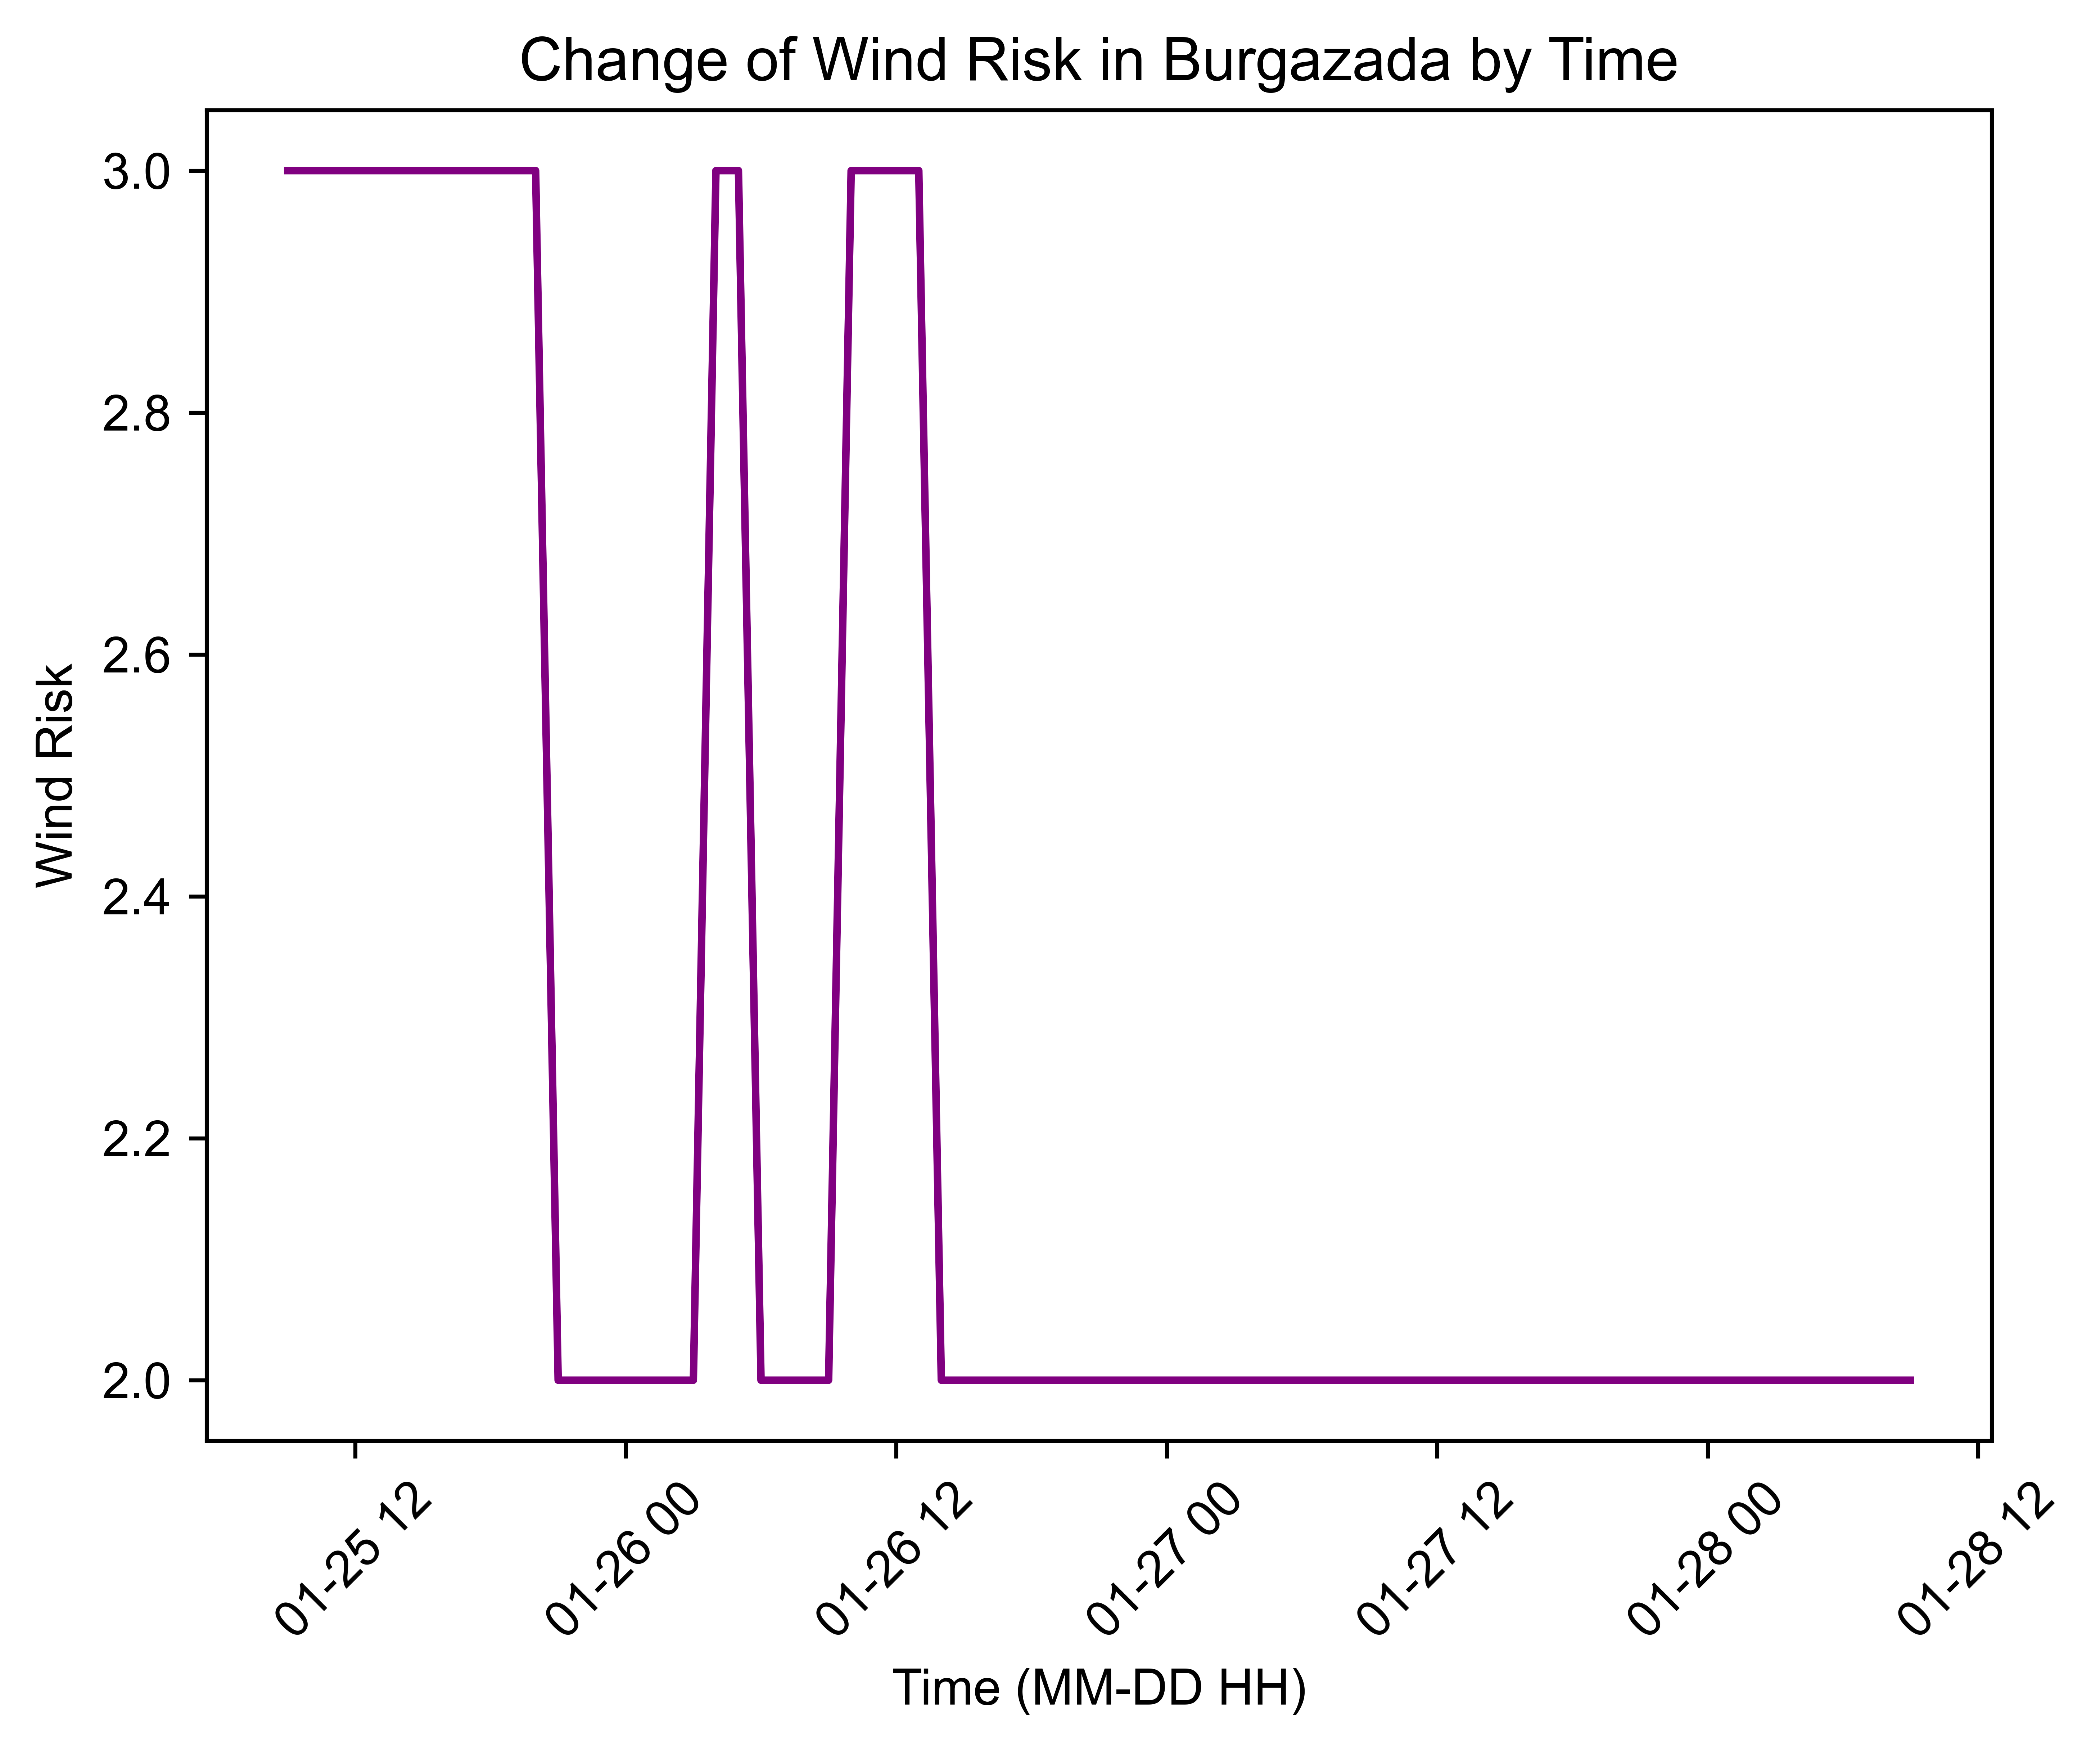

        Mahalle  Yagis_Risk  Ruzgar_Risk  Buzlanma_Risk
46893  Hallaçlı           1            1              4
46894  Hallaçlı           1            1              4
46895  Hallaçlı           1            1              4
46896  Hallaçlı           1            1              4
46897  Hallaçlı           1            1              4
...         ...         ...          ...            ...
58083  Hallaçlı           1            2              4
58084  Hallaçlı           2            1              4
58085  Hallaçlı           2            1              4
58086  Hallaçlı           2            1              4
58087  Hallaçlı           2            1              4

[73 rows x 4 columns]
46893   2022-01-25 19:00:00+03:00
46894   2022-01-25 20:00:00+03:00
46895   2022-01-25 21:00:00+03:00
46896   2022-01-26 02:00:00+03:00
46897   2022-01-26 03:00:00+03:00
                   ...           
58083   2022-01-25 18:00:00+03:00
58084   2022-01-25 22:00:00+03:00
58085   2022-01-25 23:00:00+03:00

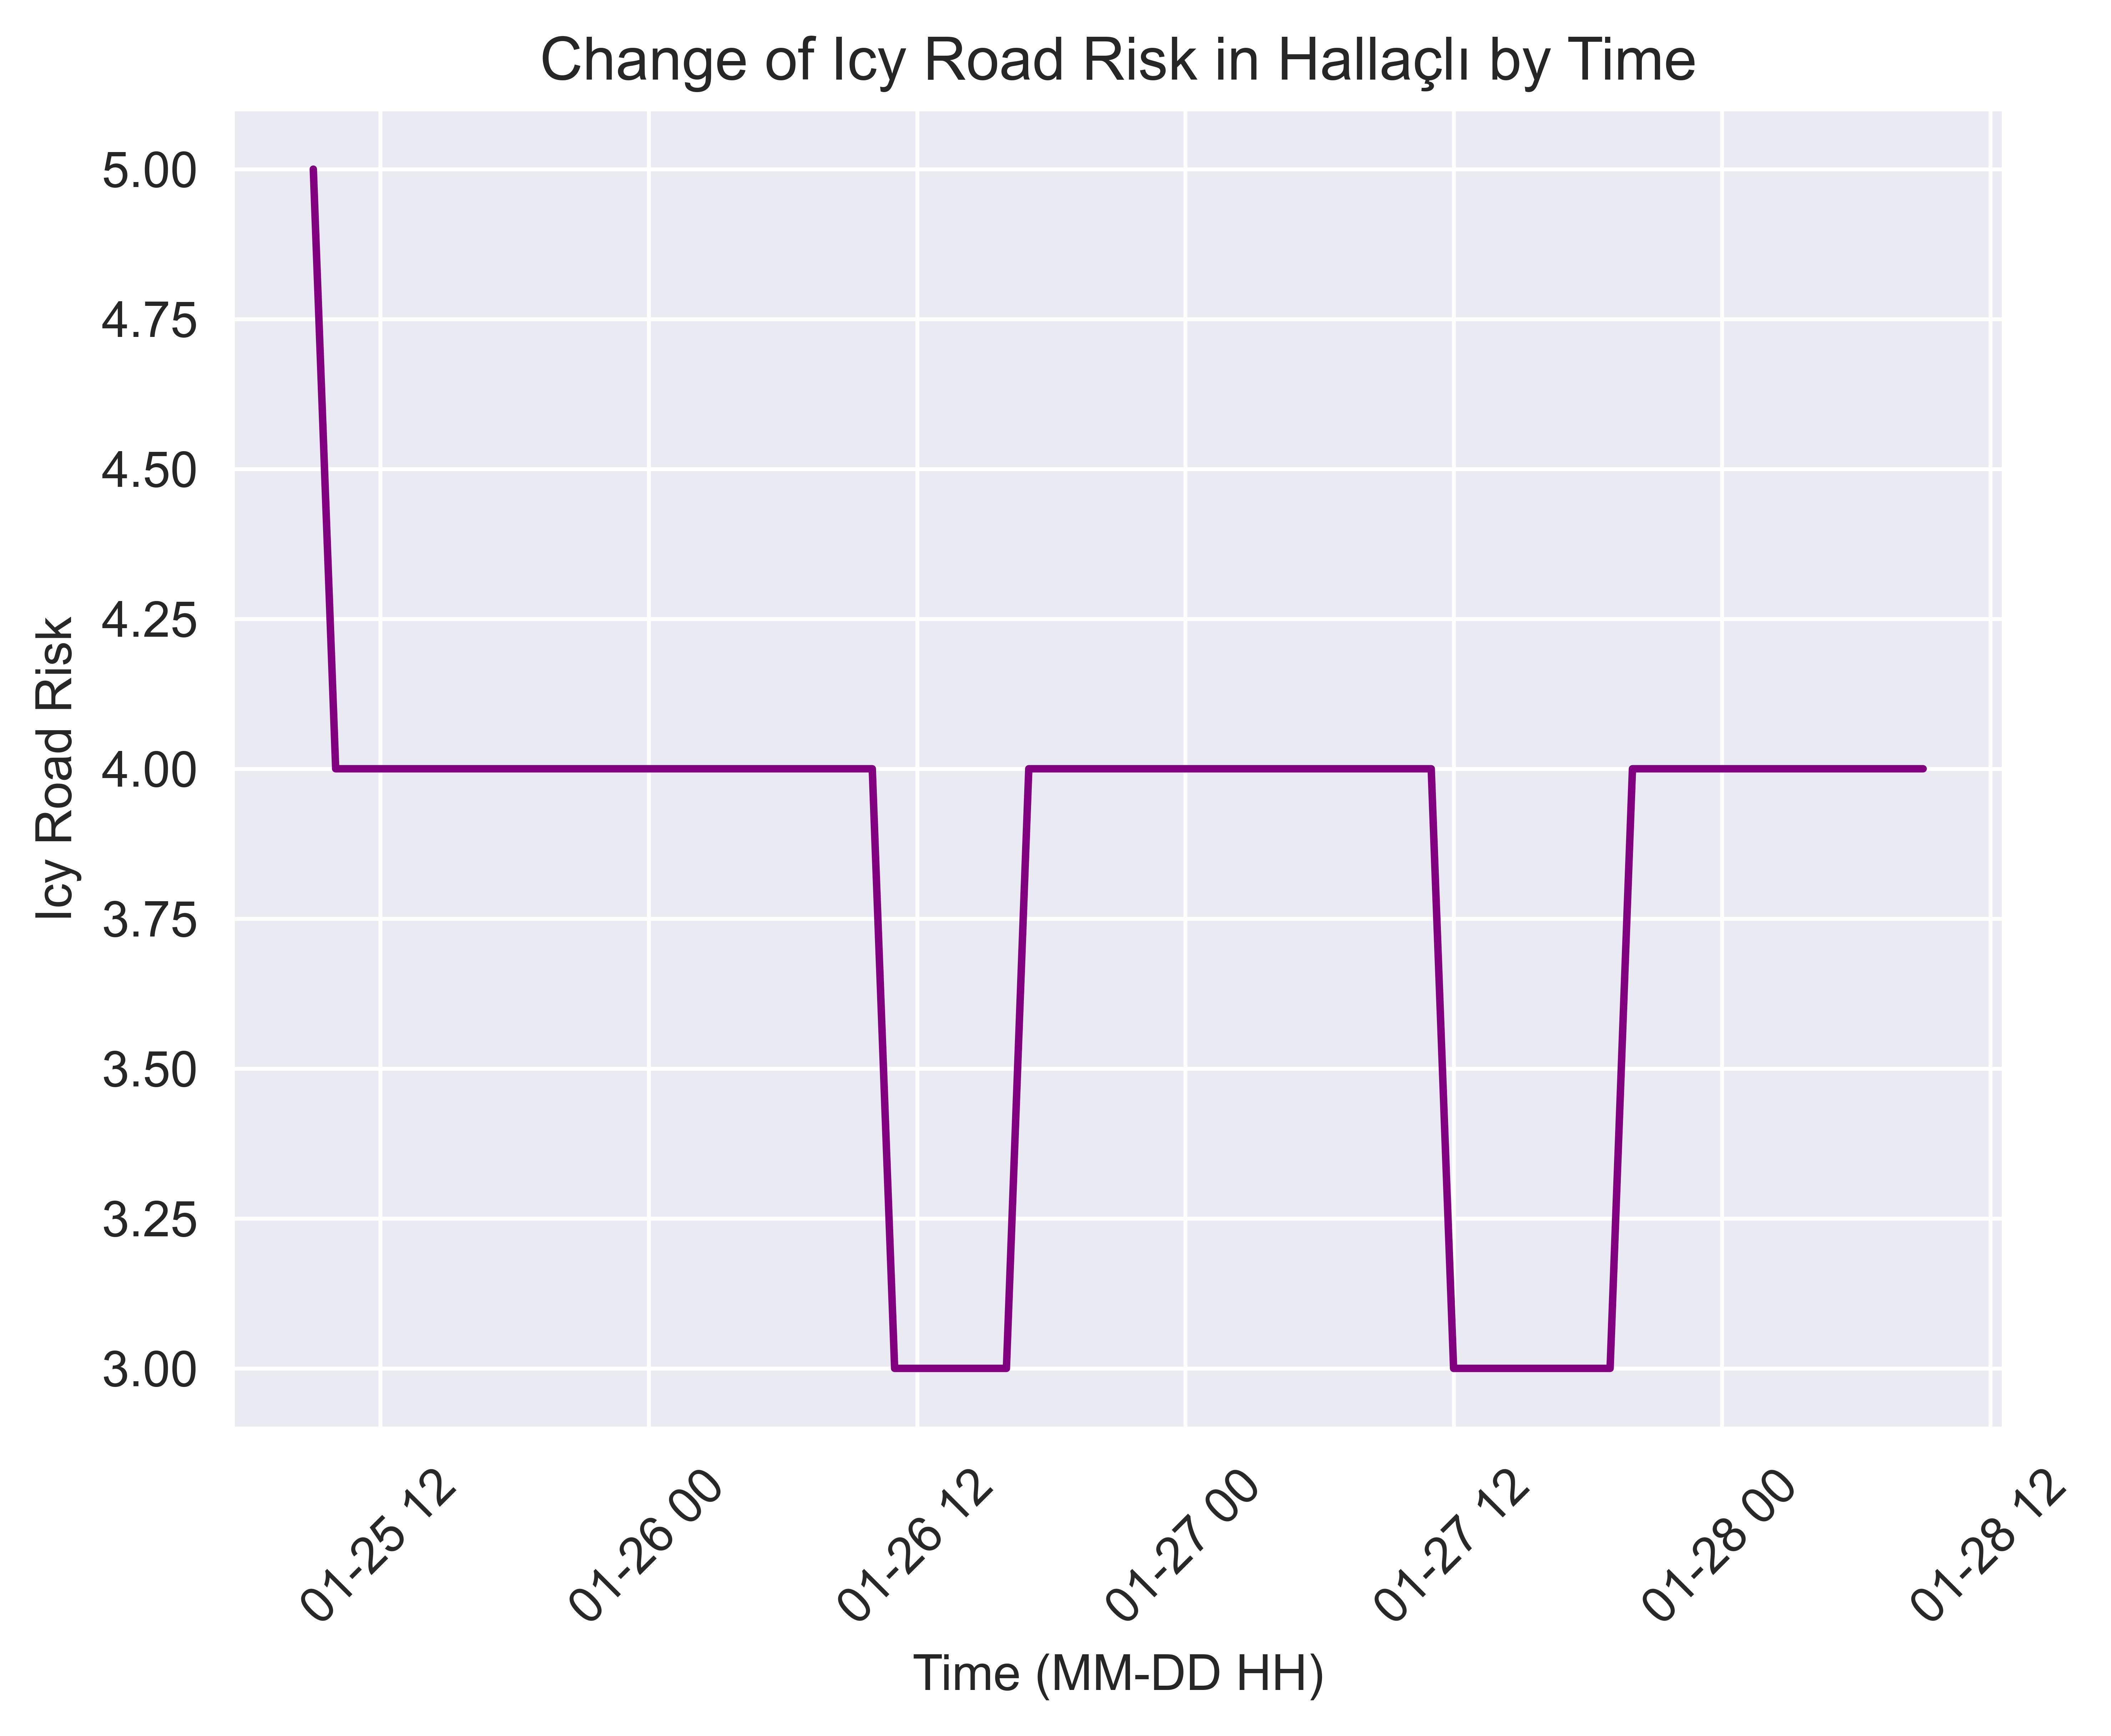

          Mahalle  Yagis_Risk  Ruzgar_Risk  Buzlanma_Risk
40117  Hacı Kasım           1            2              3
40118  Hacı Kasım           1            3              3
40119  Hacı Kasım           2            3              3
40120  Hacı Kasım           2            3              3
40121  Hacı Kasım           1            3              3
...           ...         ...          ...            ...
40185  Hacı Kasım           1            2              3
40186  Hacı Kasım           1            2              3
40187  Hacı Kasım           1            2              3
40188  Hacı Kasım           1            2              3
40189  Hacı Kasım           1            2              3

[73 rows x 4 columns]
40117   2022-01-25 09:00:00+03:00
40118   2022-01-25 10:00:00+03:00
40119   2022-01-25 11:00:00+03:00
40120   2022-01-25 12:00:00+03:00
40121   2022-01-25 13:00:00+03:00
                   ...           
40185   2022-01-28 05:00:00+03:00
40186   2022-01-28 06:00:00+03:00
40187   2

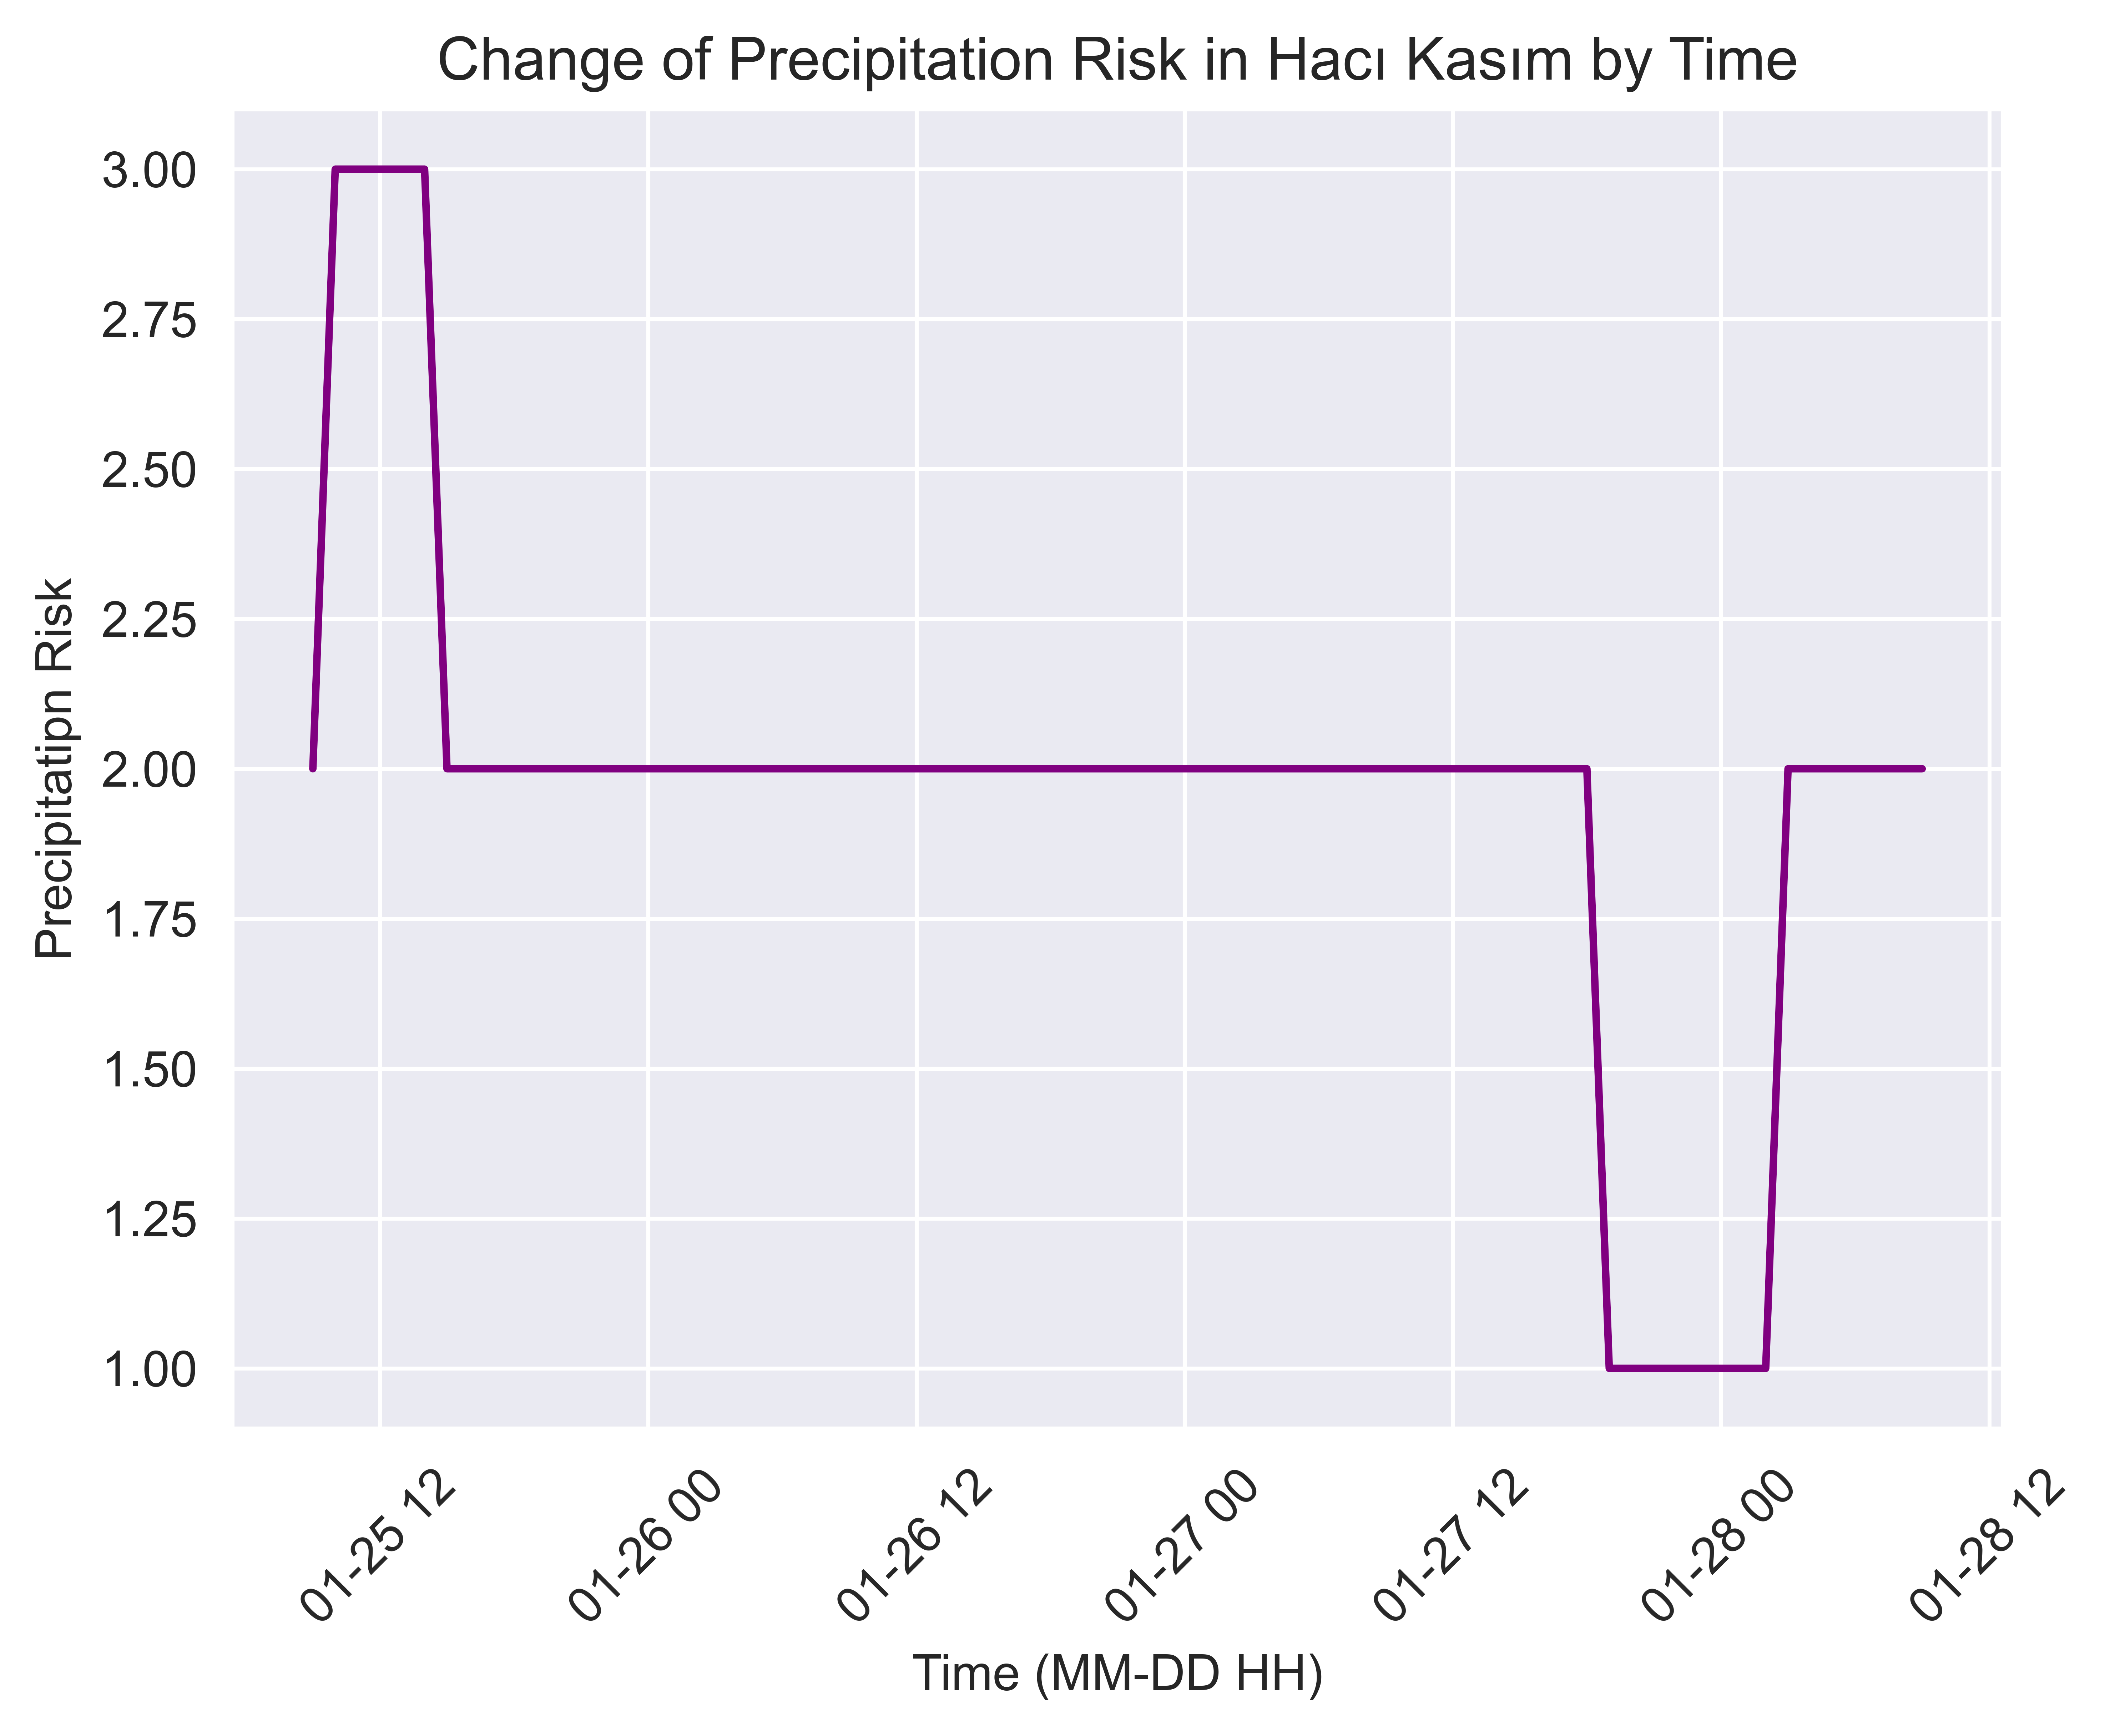

In [13]:
# the neighbourhood that has the max. risk for wind
max_wind_nbh = df_nbhWind['Mahalle'].tolist()[0] # Burgazada is the output

df_maxWind_time = df2.loc[df['Mahalle'] ==max_wind_nbh]
print(df_maxWind_time[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']])

df_burgazada = df2.loc[df2['Mahalle'] == 'Burgazada']
print(df_burgazada['local_times'])

# plot the wind risk for Burgazada by time
plt.rcParams["figure.dpi"] = 1000
burgazada_riskplot = sns.lineplot(data=df_burgazada, x= 'local_times',y= 'Ruzgar_Risk', c='purple')
sns.set_style("darkgrid")
plt.xticks(rotation=45)
plt.xlabel('Time (MM-DD HH)')
plt.ylabel('Wind Risk')
plt.title('Change of Wind Risk in Burgazada by Time')
plt.show()

# the neighbourhood that has the max. risk for icy road
max_icy_nbh = df_nbhIcy['Mahalle'].tolist()[0] # Hallacli is the output

df_maxIcy_time = df2.loc[df['Mahalle'] ==max_icy_nbh]
print(df_maxIcy_time[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']])

df_hallacli = df2.loc[df2['Mahalle'] == 'Hallaçlı']
print(df_hallacli['local_times'])

# plot the icy road risk for Hallaçlı by time
plt.rcParams["figure.dpi"] = 1000
hallacli_riskplot = sns.lineplot(data=df_hallacli, x= 'local_times',y= 'Buzlanma_Risk', c='purple')
sns.set_style("darkgrid")
plt.xticks(rotation=45)
plt.xlabel('Time (MM-DD HH)')
plt.ylabel('Icy Road Risk')
plt.title('Change of Icy Road Risk in Hallaçlı by Time')
plt.show()

# the neighbourhood that has the max. risk for precipitation
max_prec_nbh = df_nbhPrec['Mahalle'].tolist()[0] # Hacikasim is the output

df_maxPrec_time = df2.loc[df['Mahalle'] ==max_prec_nbh]
print(df_maxPrec_time[['Mahalle', 'Yagis_Risk', 'Ruzgar_Risk', 'Buzlanma_Risk']])

df_hacikasim = df2.loc[df2['Mahalle'] == 'Hacı Kasım']
print(df_hacikasim['local_times'])

# plot the wind risk for Hacikasim by time
plt.rcParams["figure.dpi"] = 1000
hacikasim_riskplot = sns.lineplot(data=df_hacikasim, x= 'local_times',y= 'Ruzgar_Risk', c='purple')
sns.set_style("darkgrid")
plt.xticks(rotation=45)
plt.xlabel('Time (MM-DD HH)')
plt.ylabel('Precipitatipn Risk')
plt.title('Change of Precipitation Risk in Hacı Kasım by Time')
plt.show()


Finally, we execute our previously created functions to plot data we desired for the analysis.

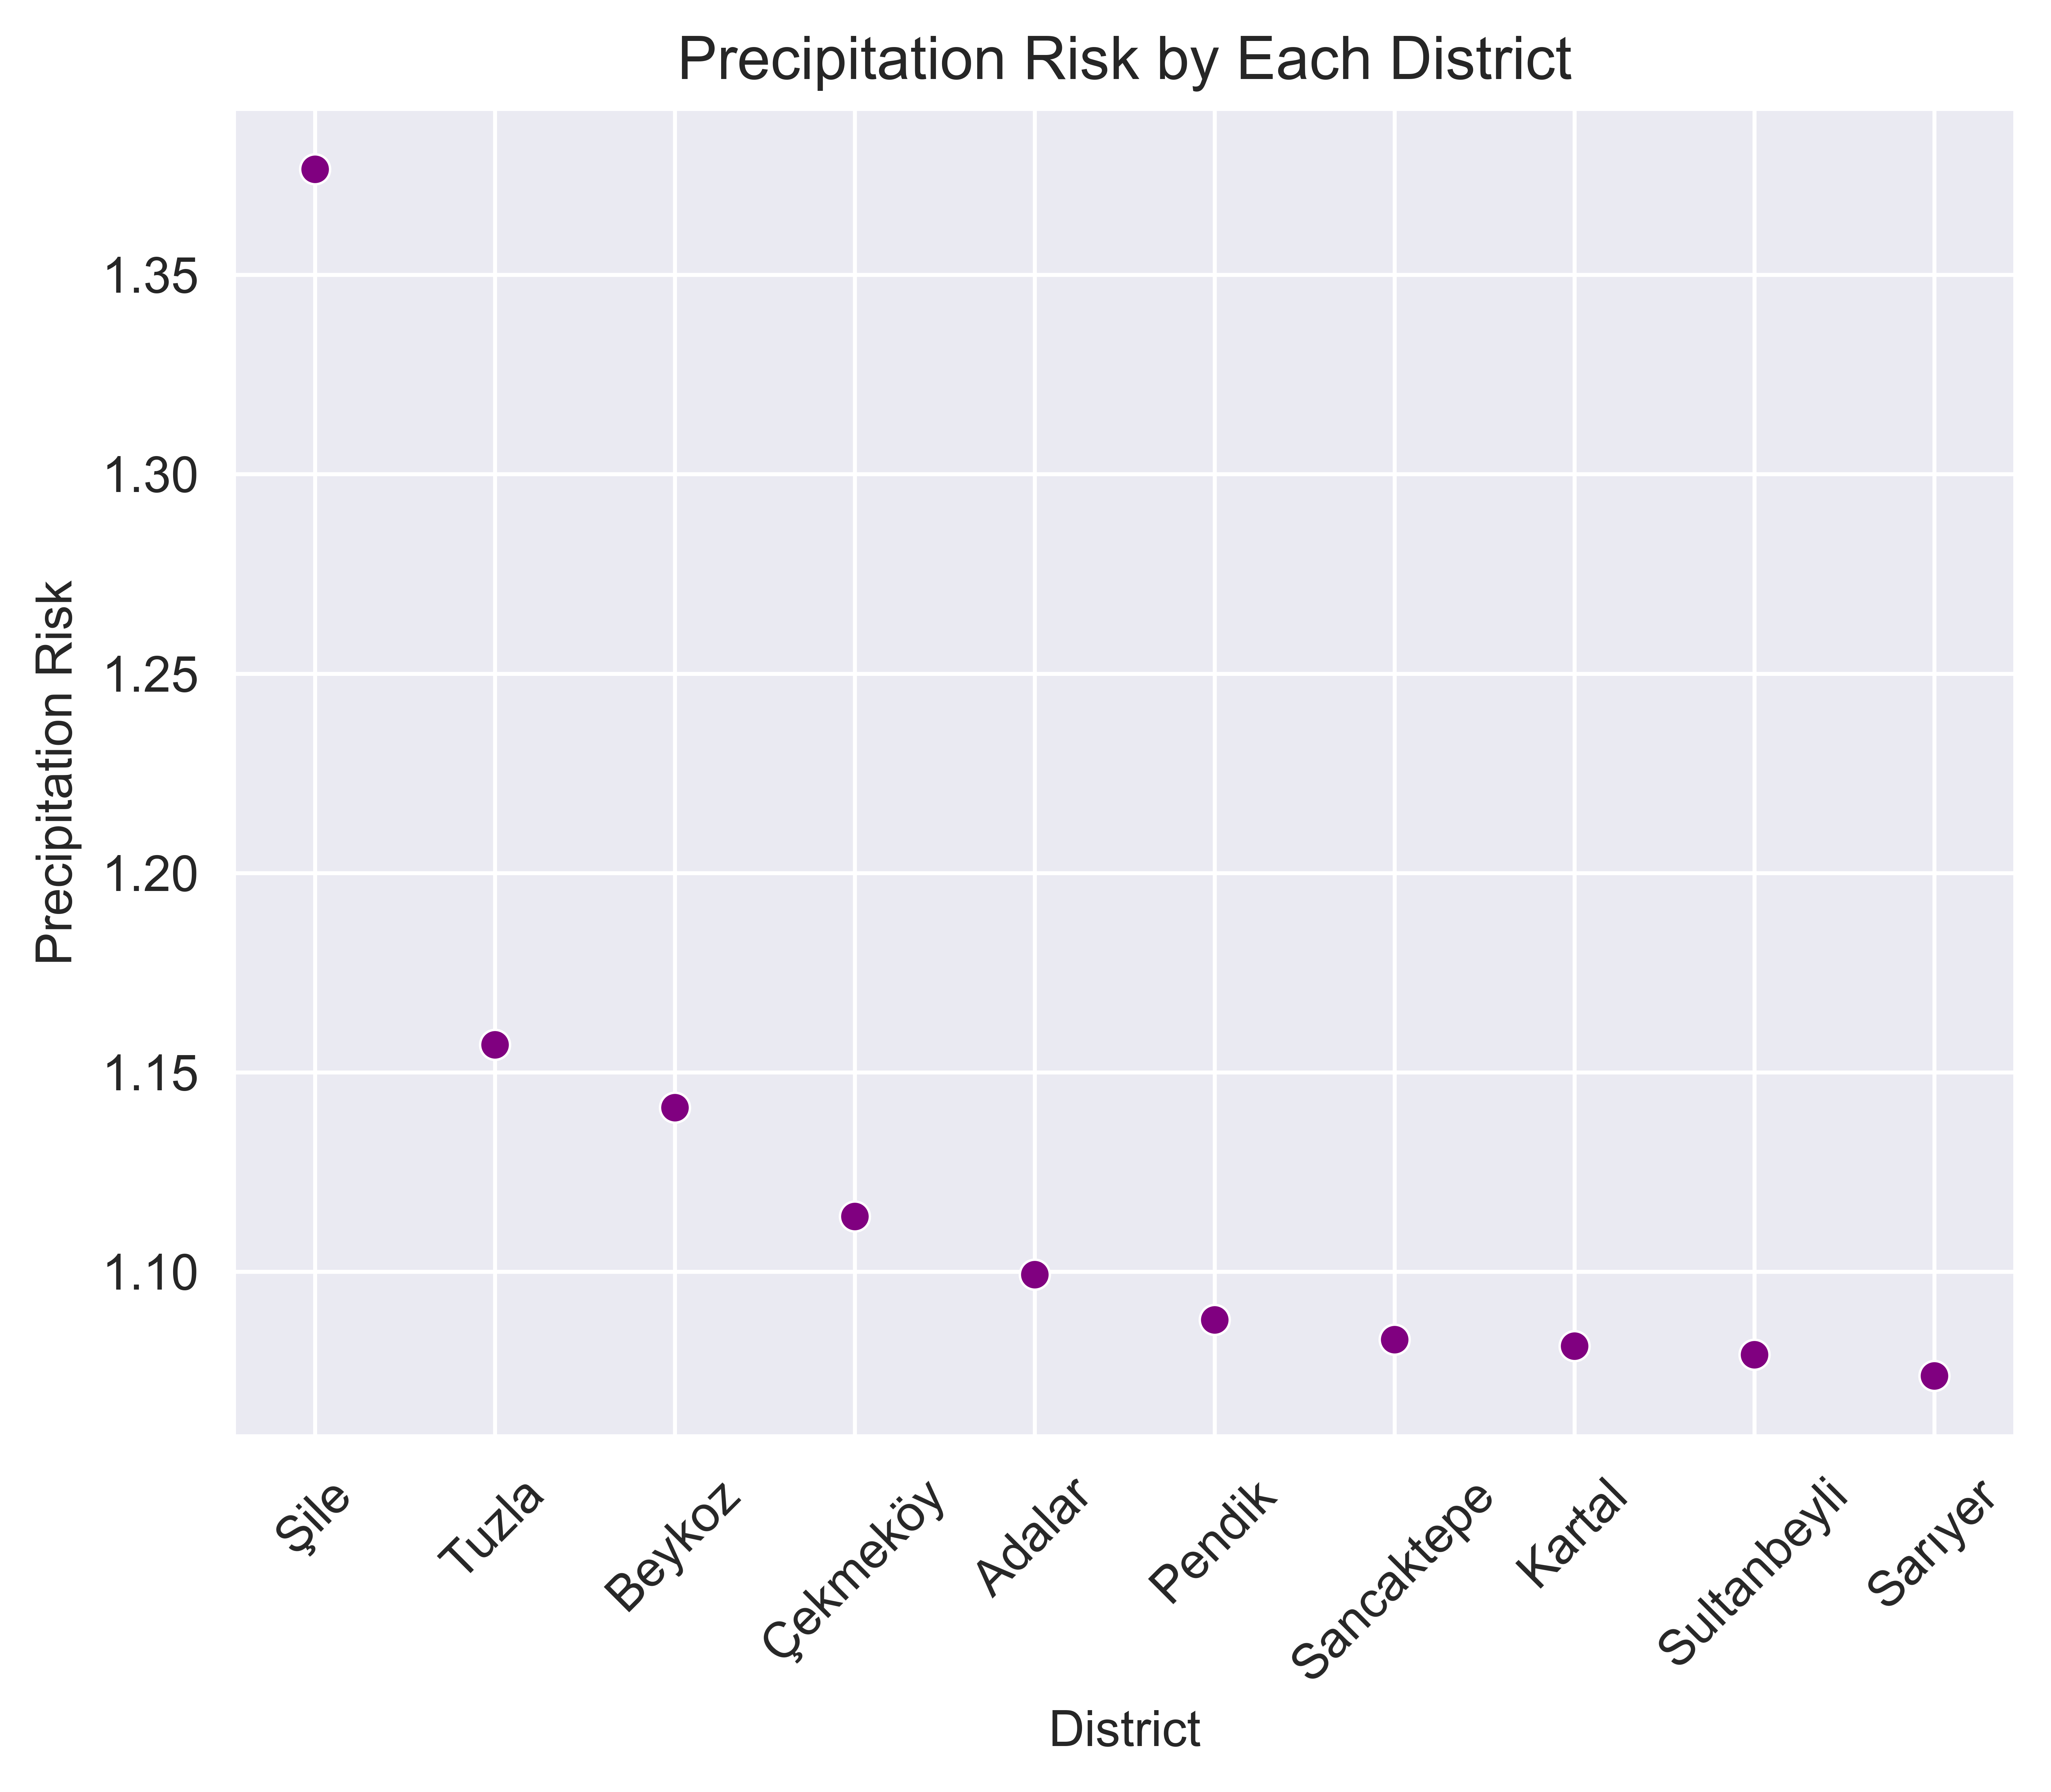

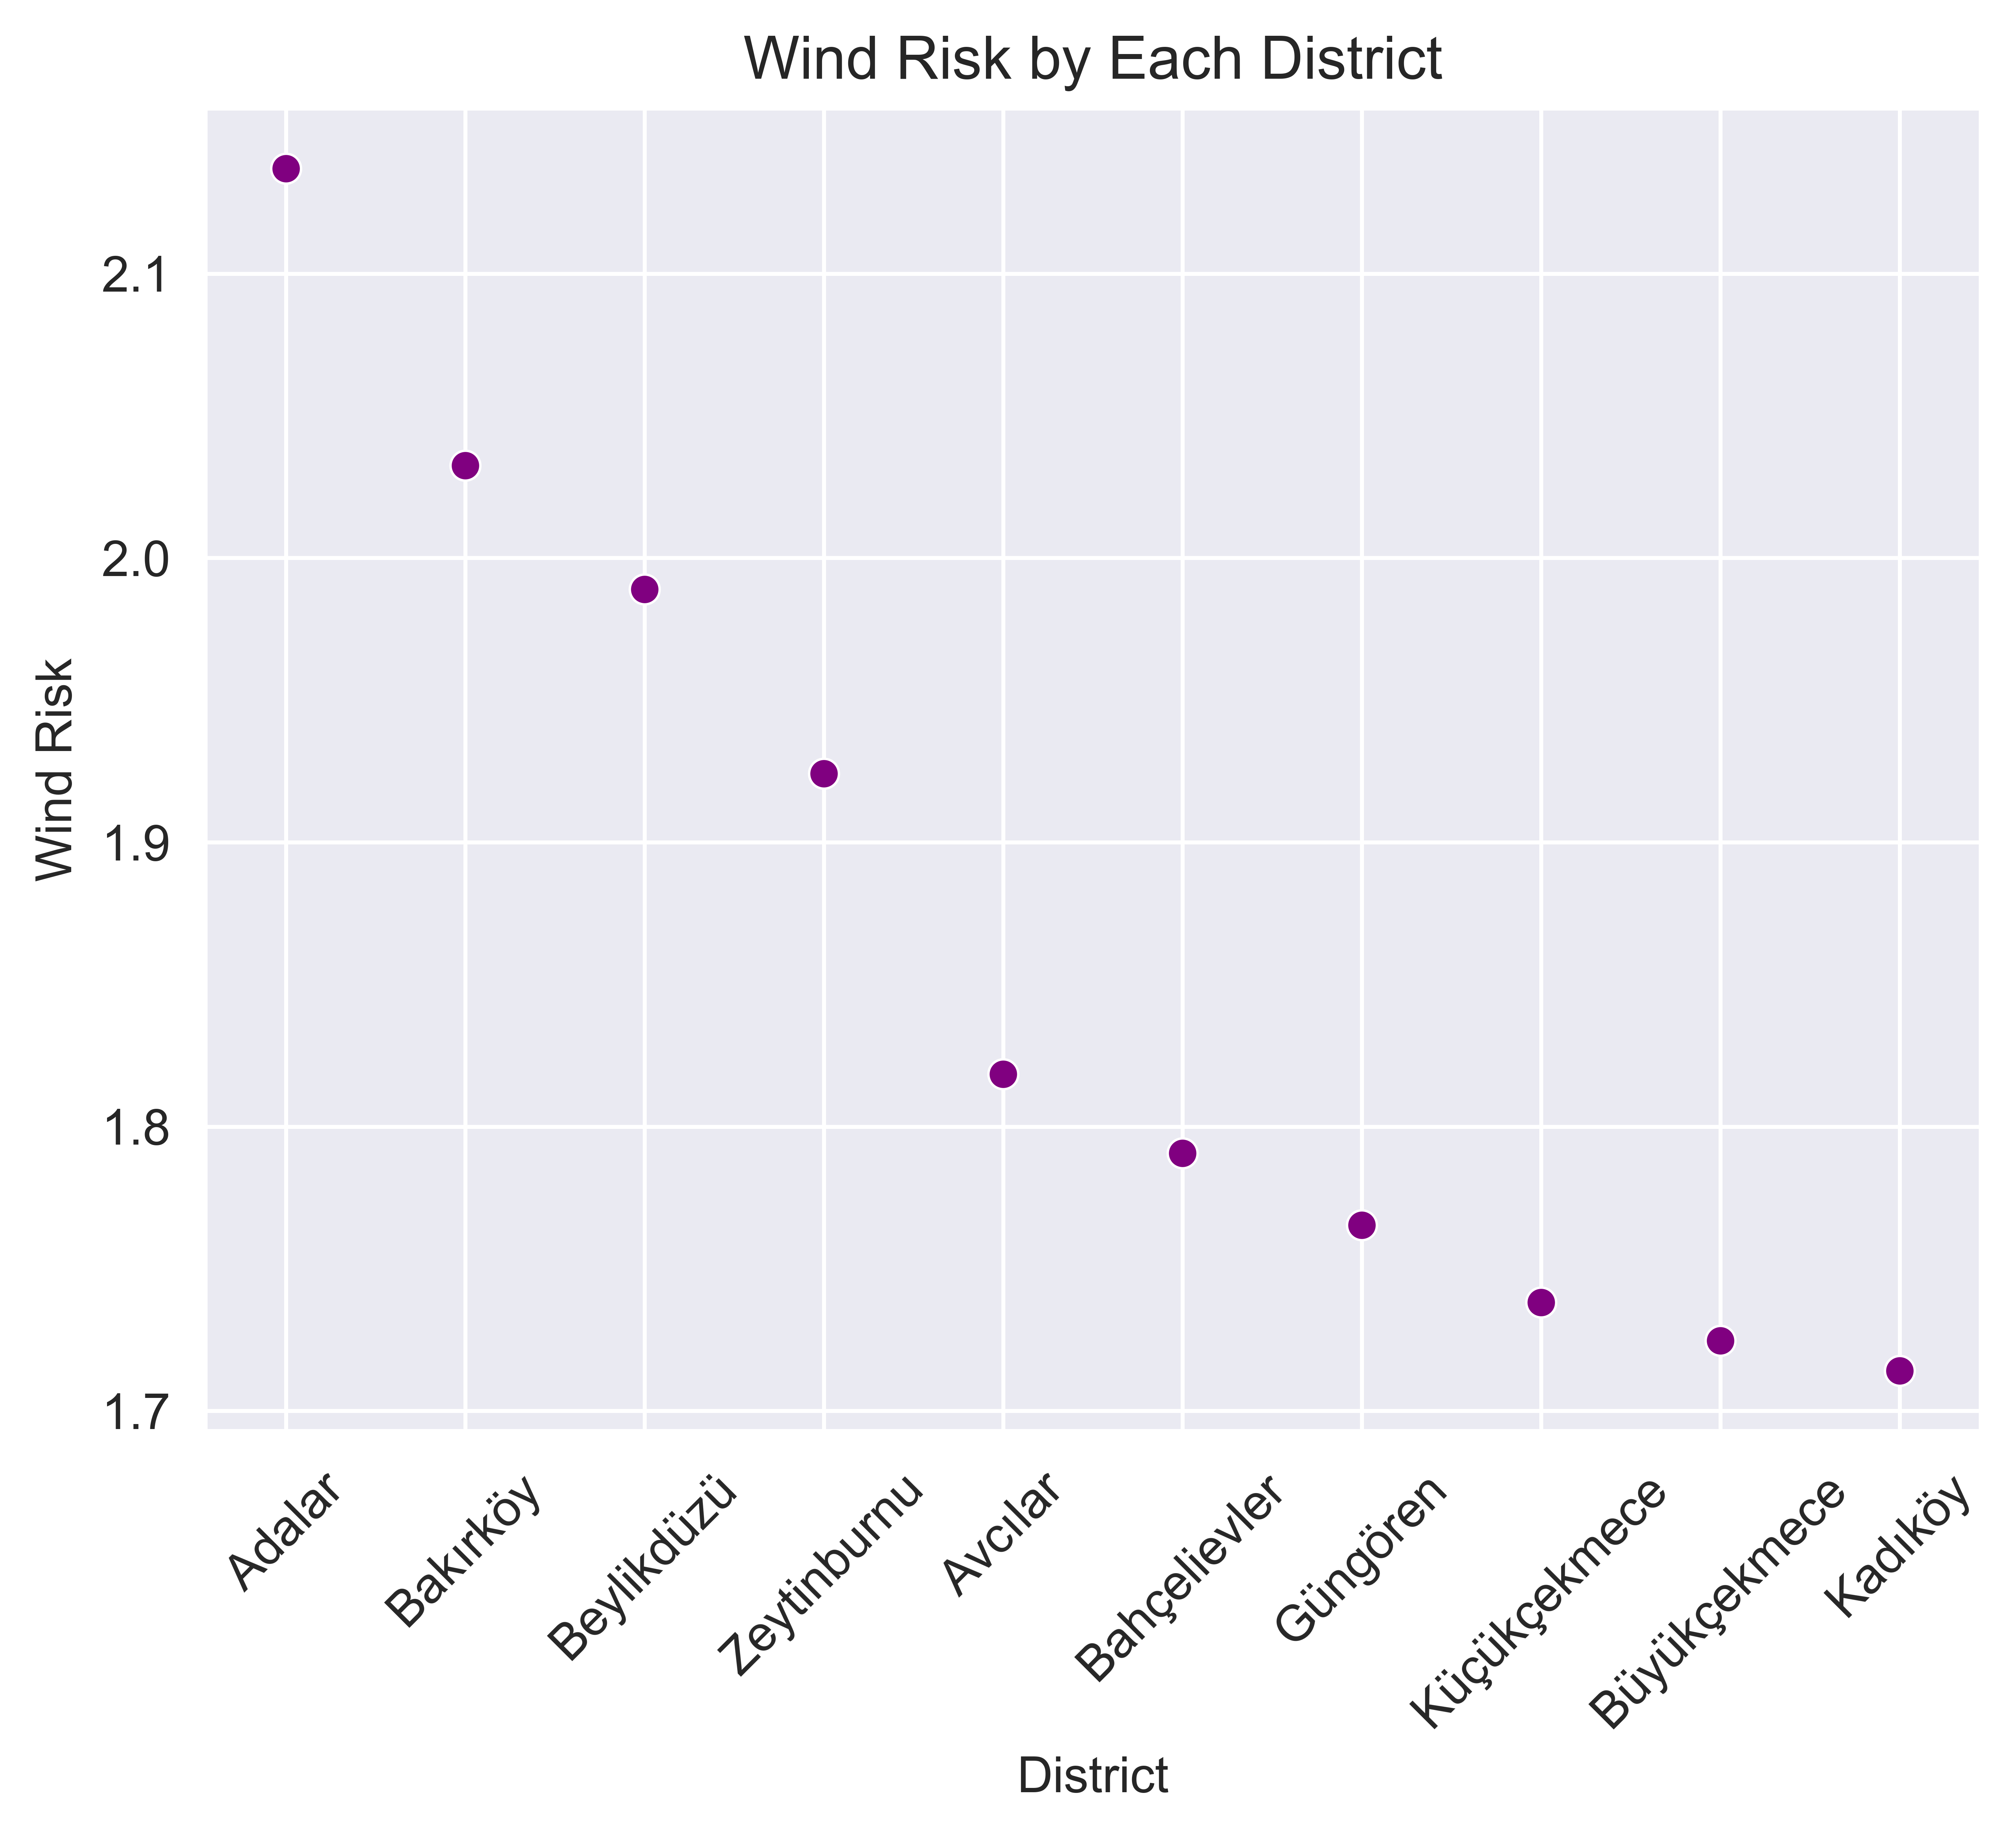

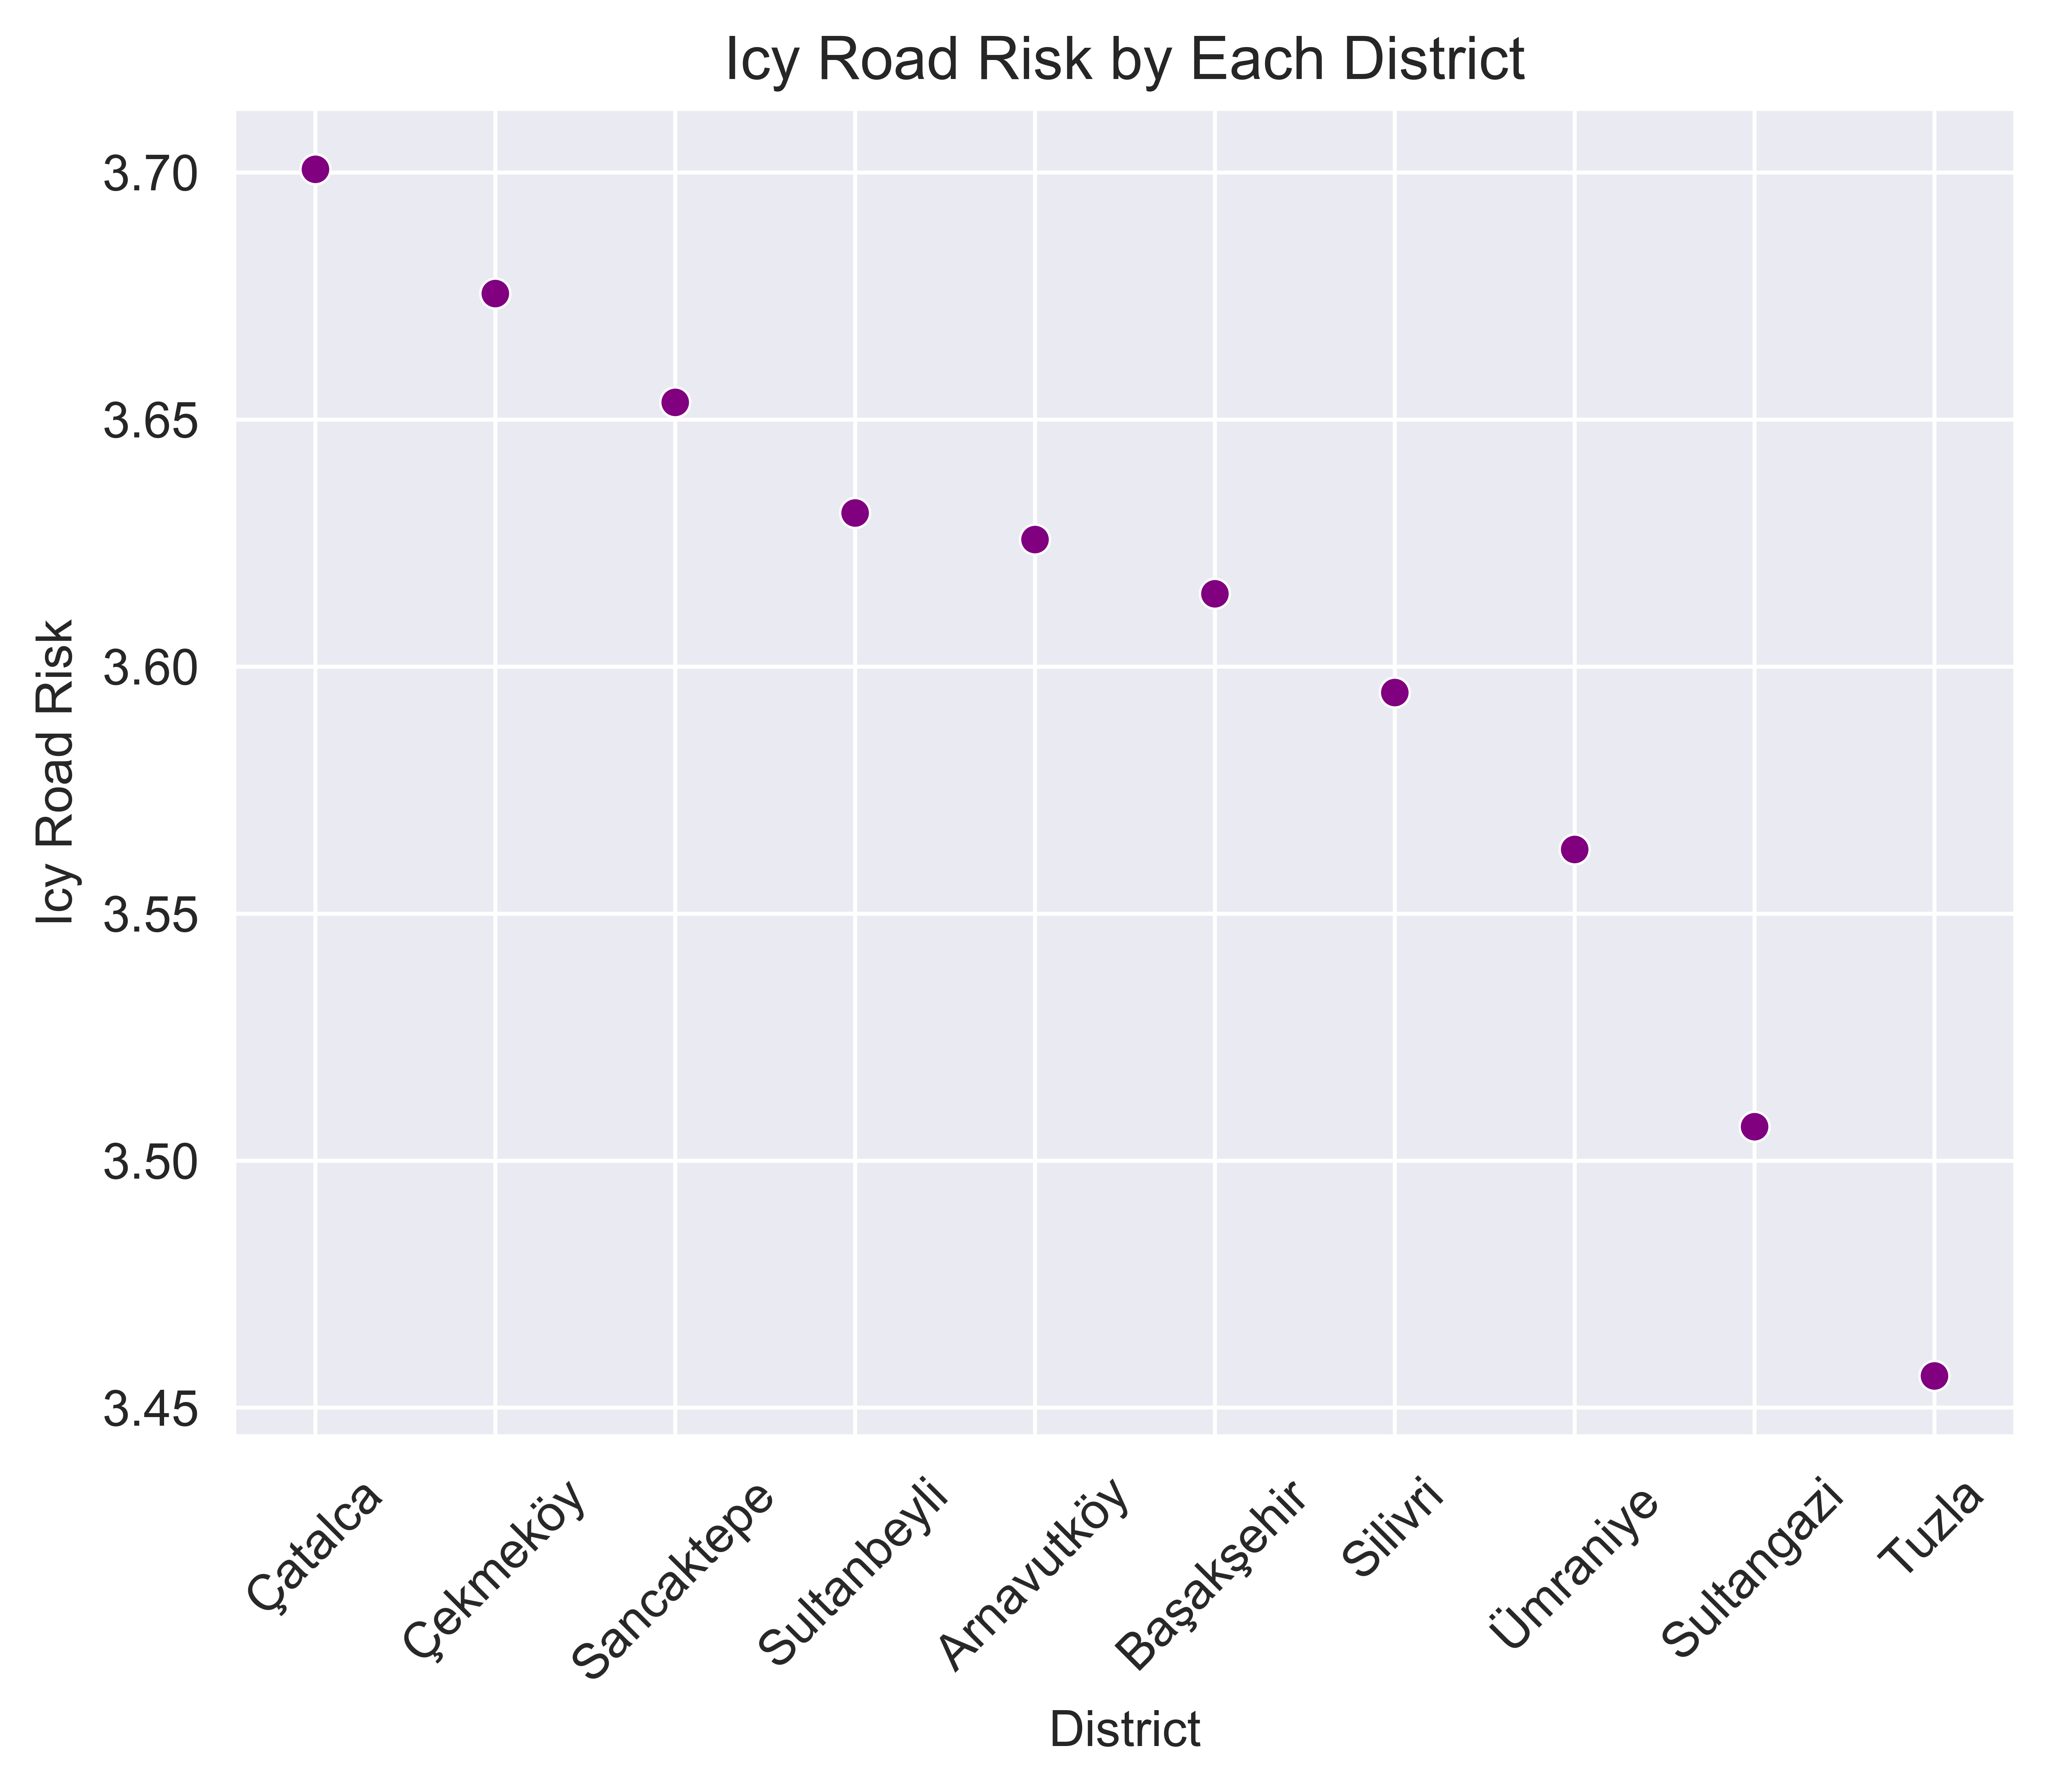

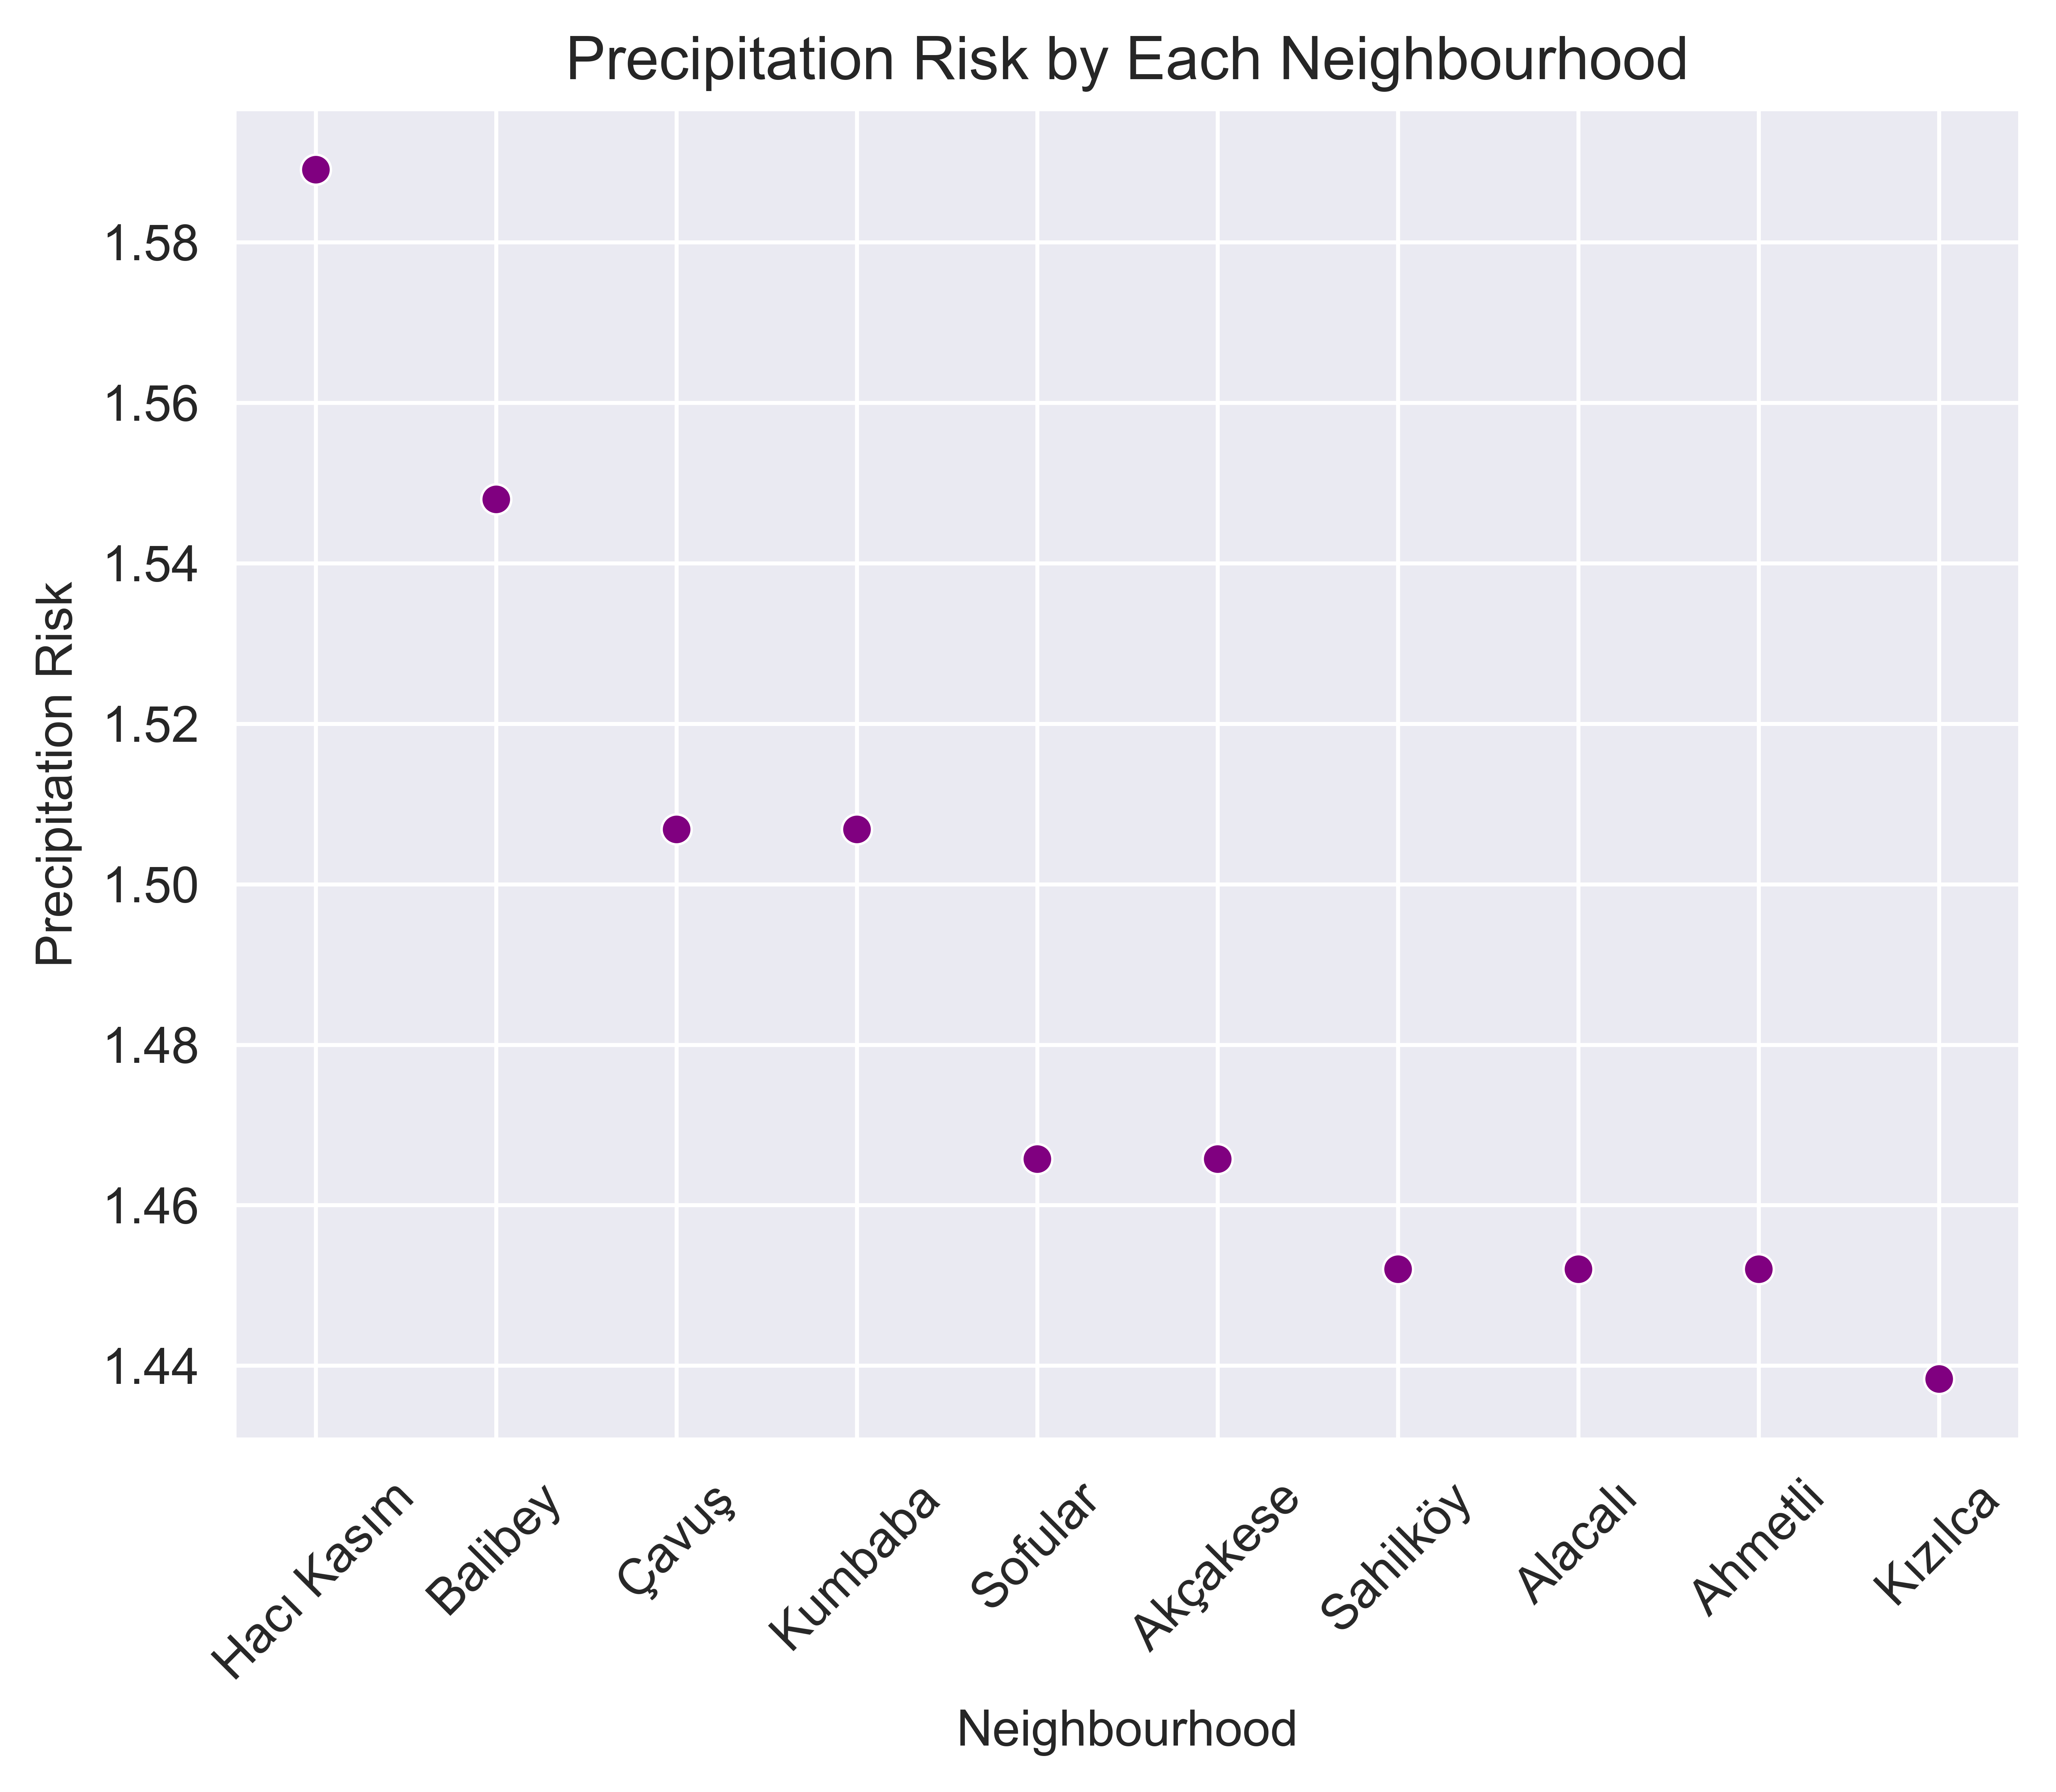

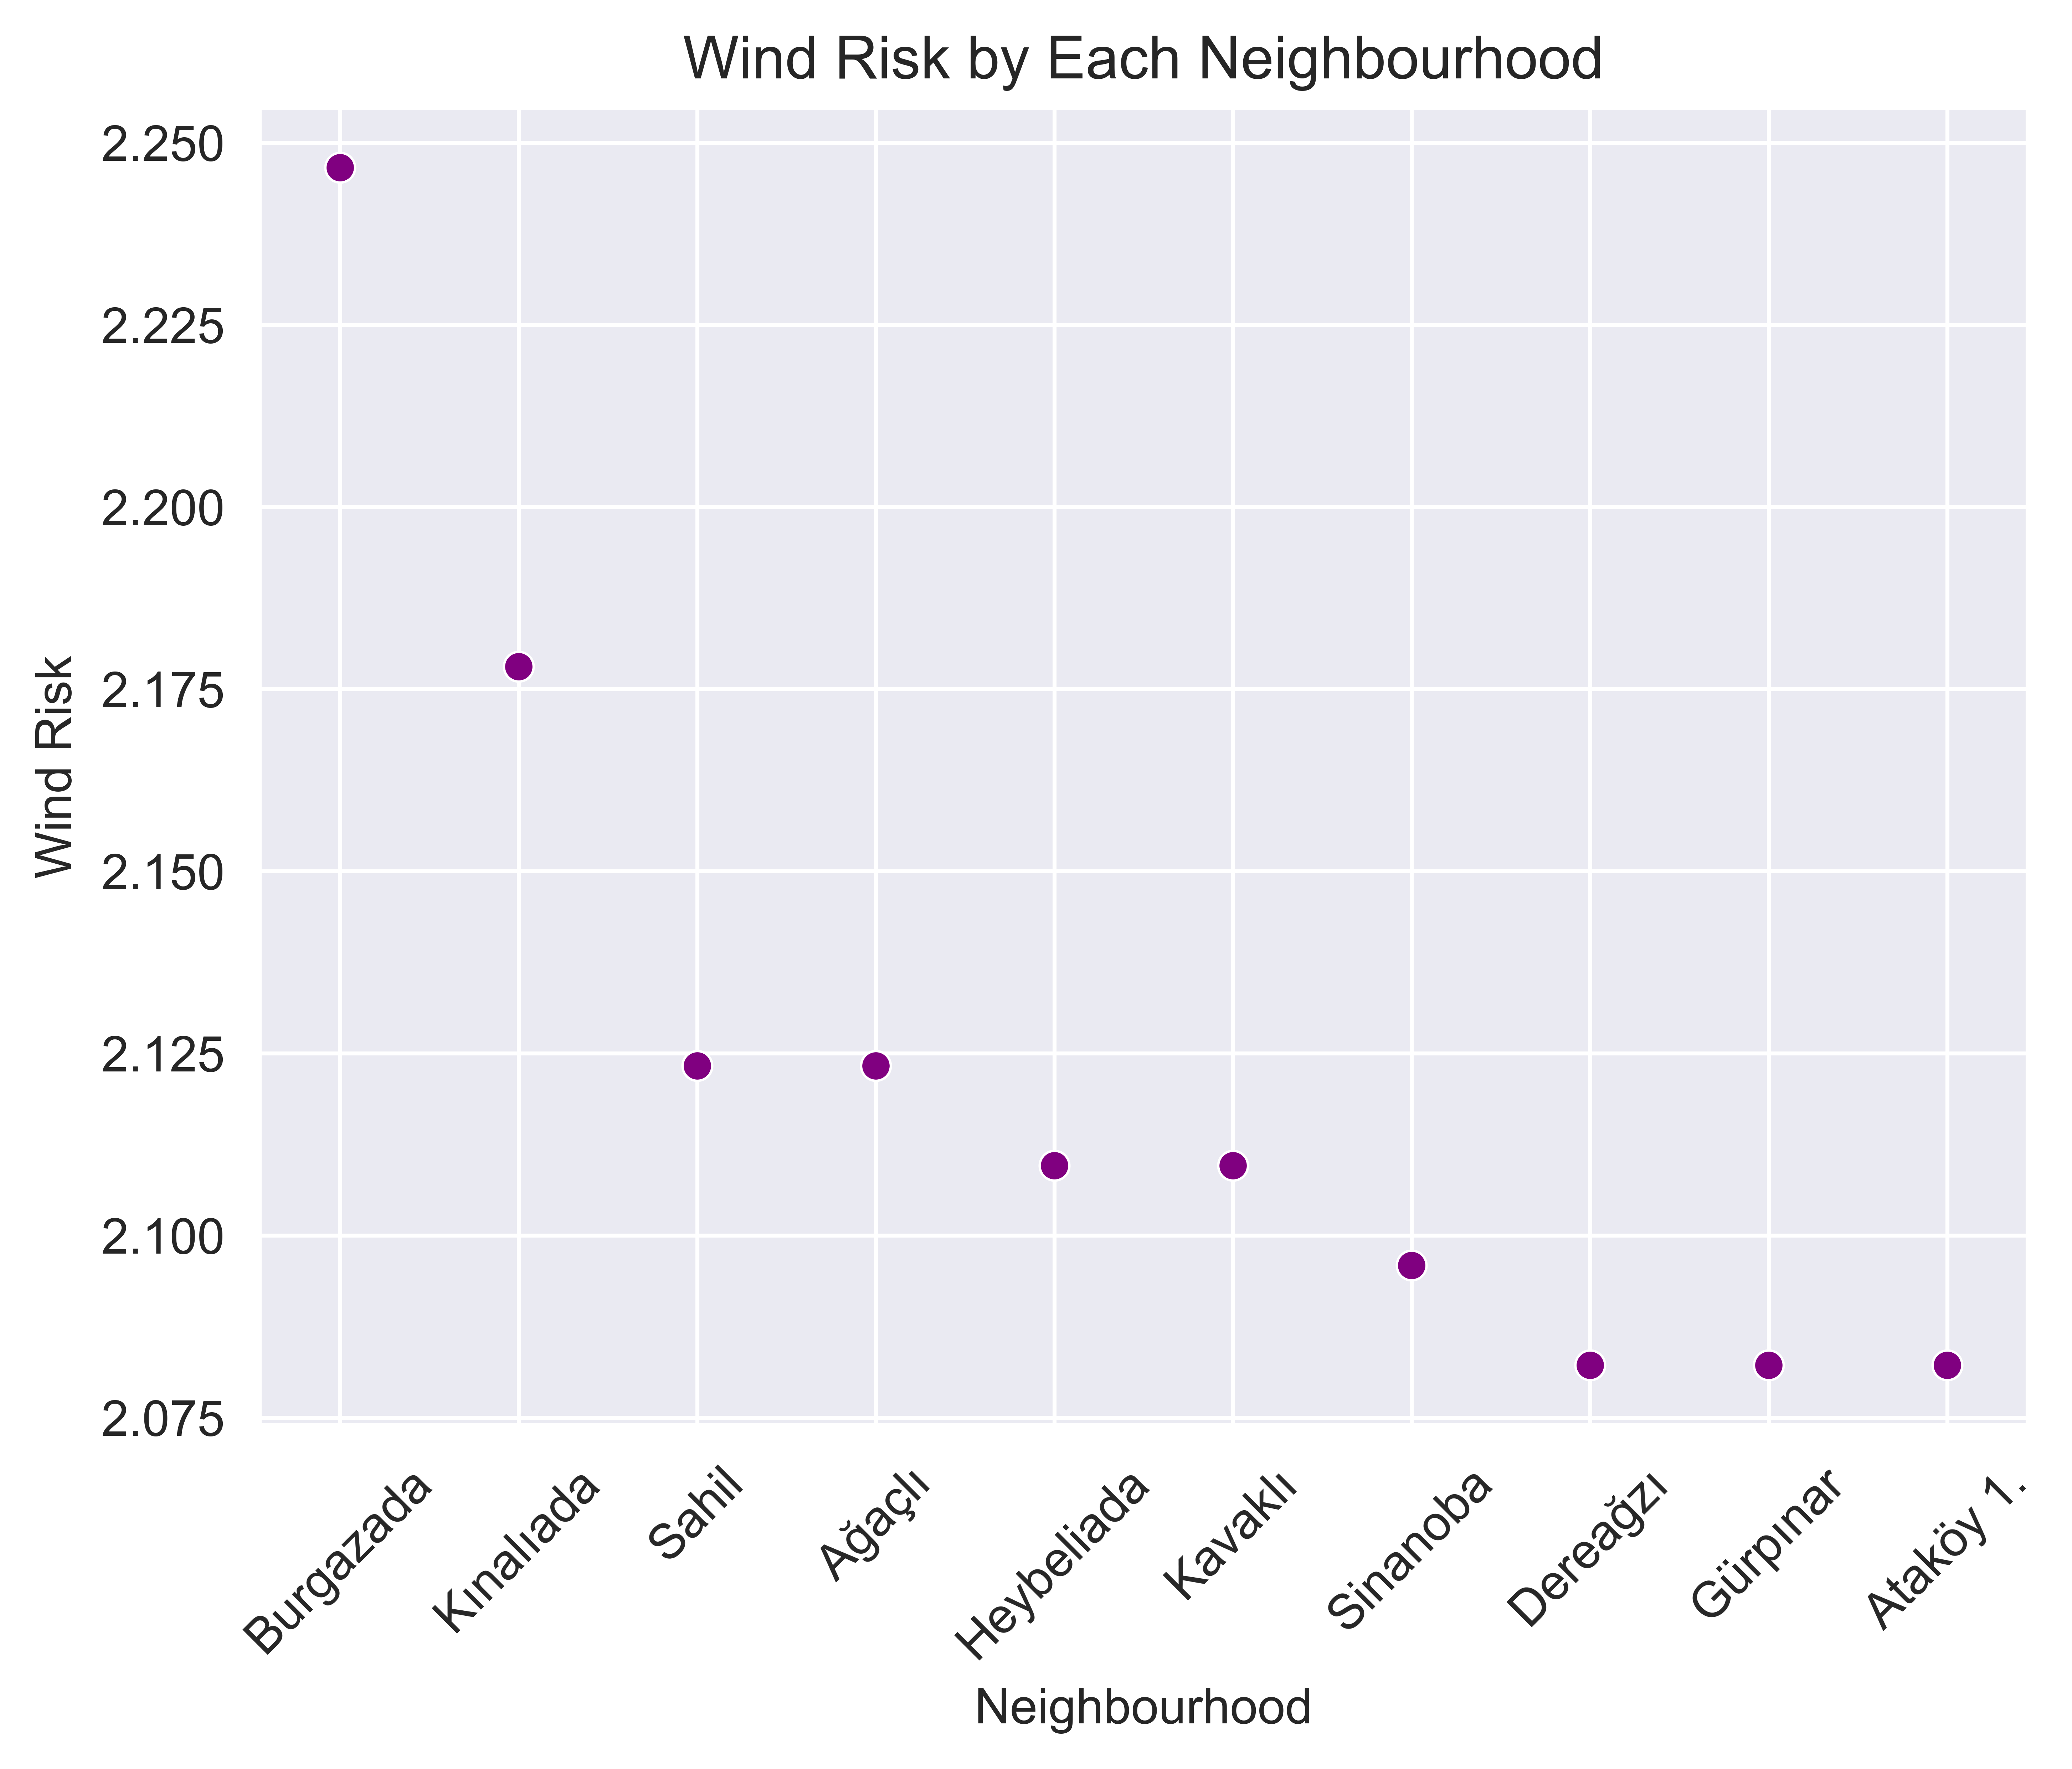

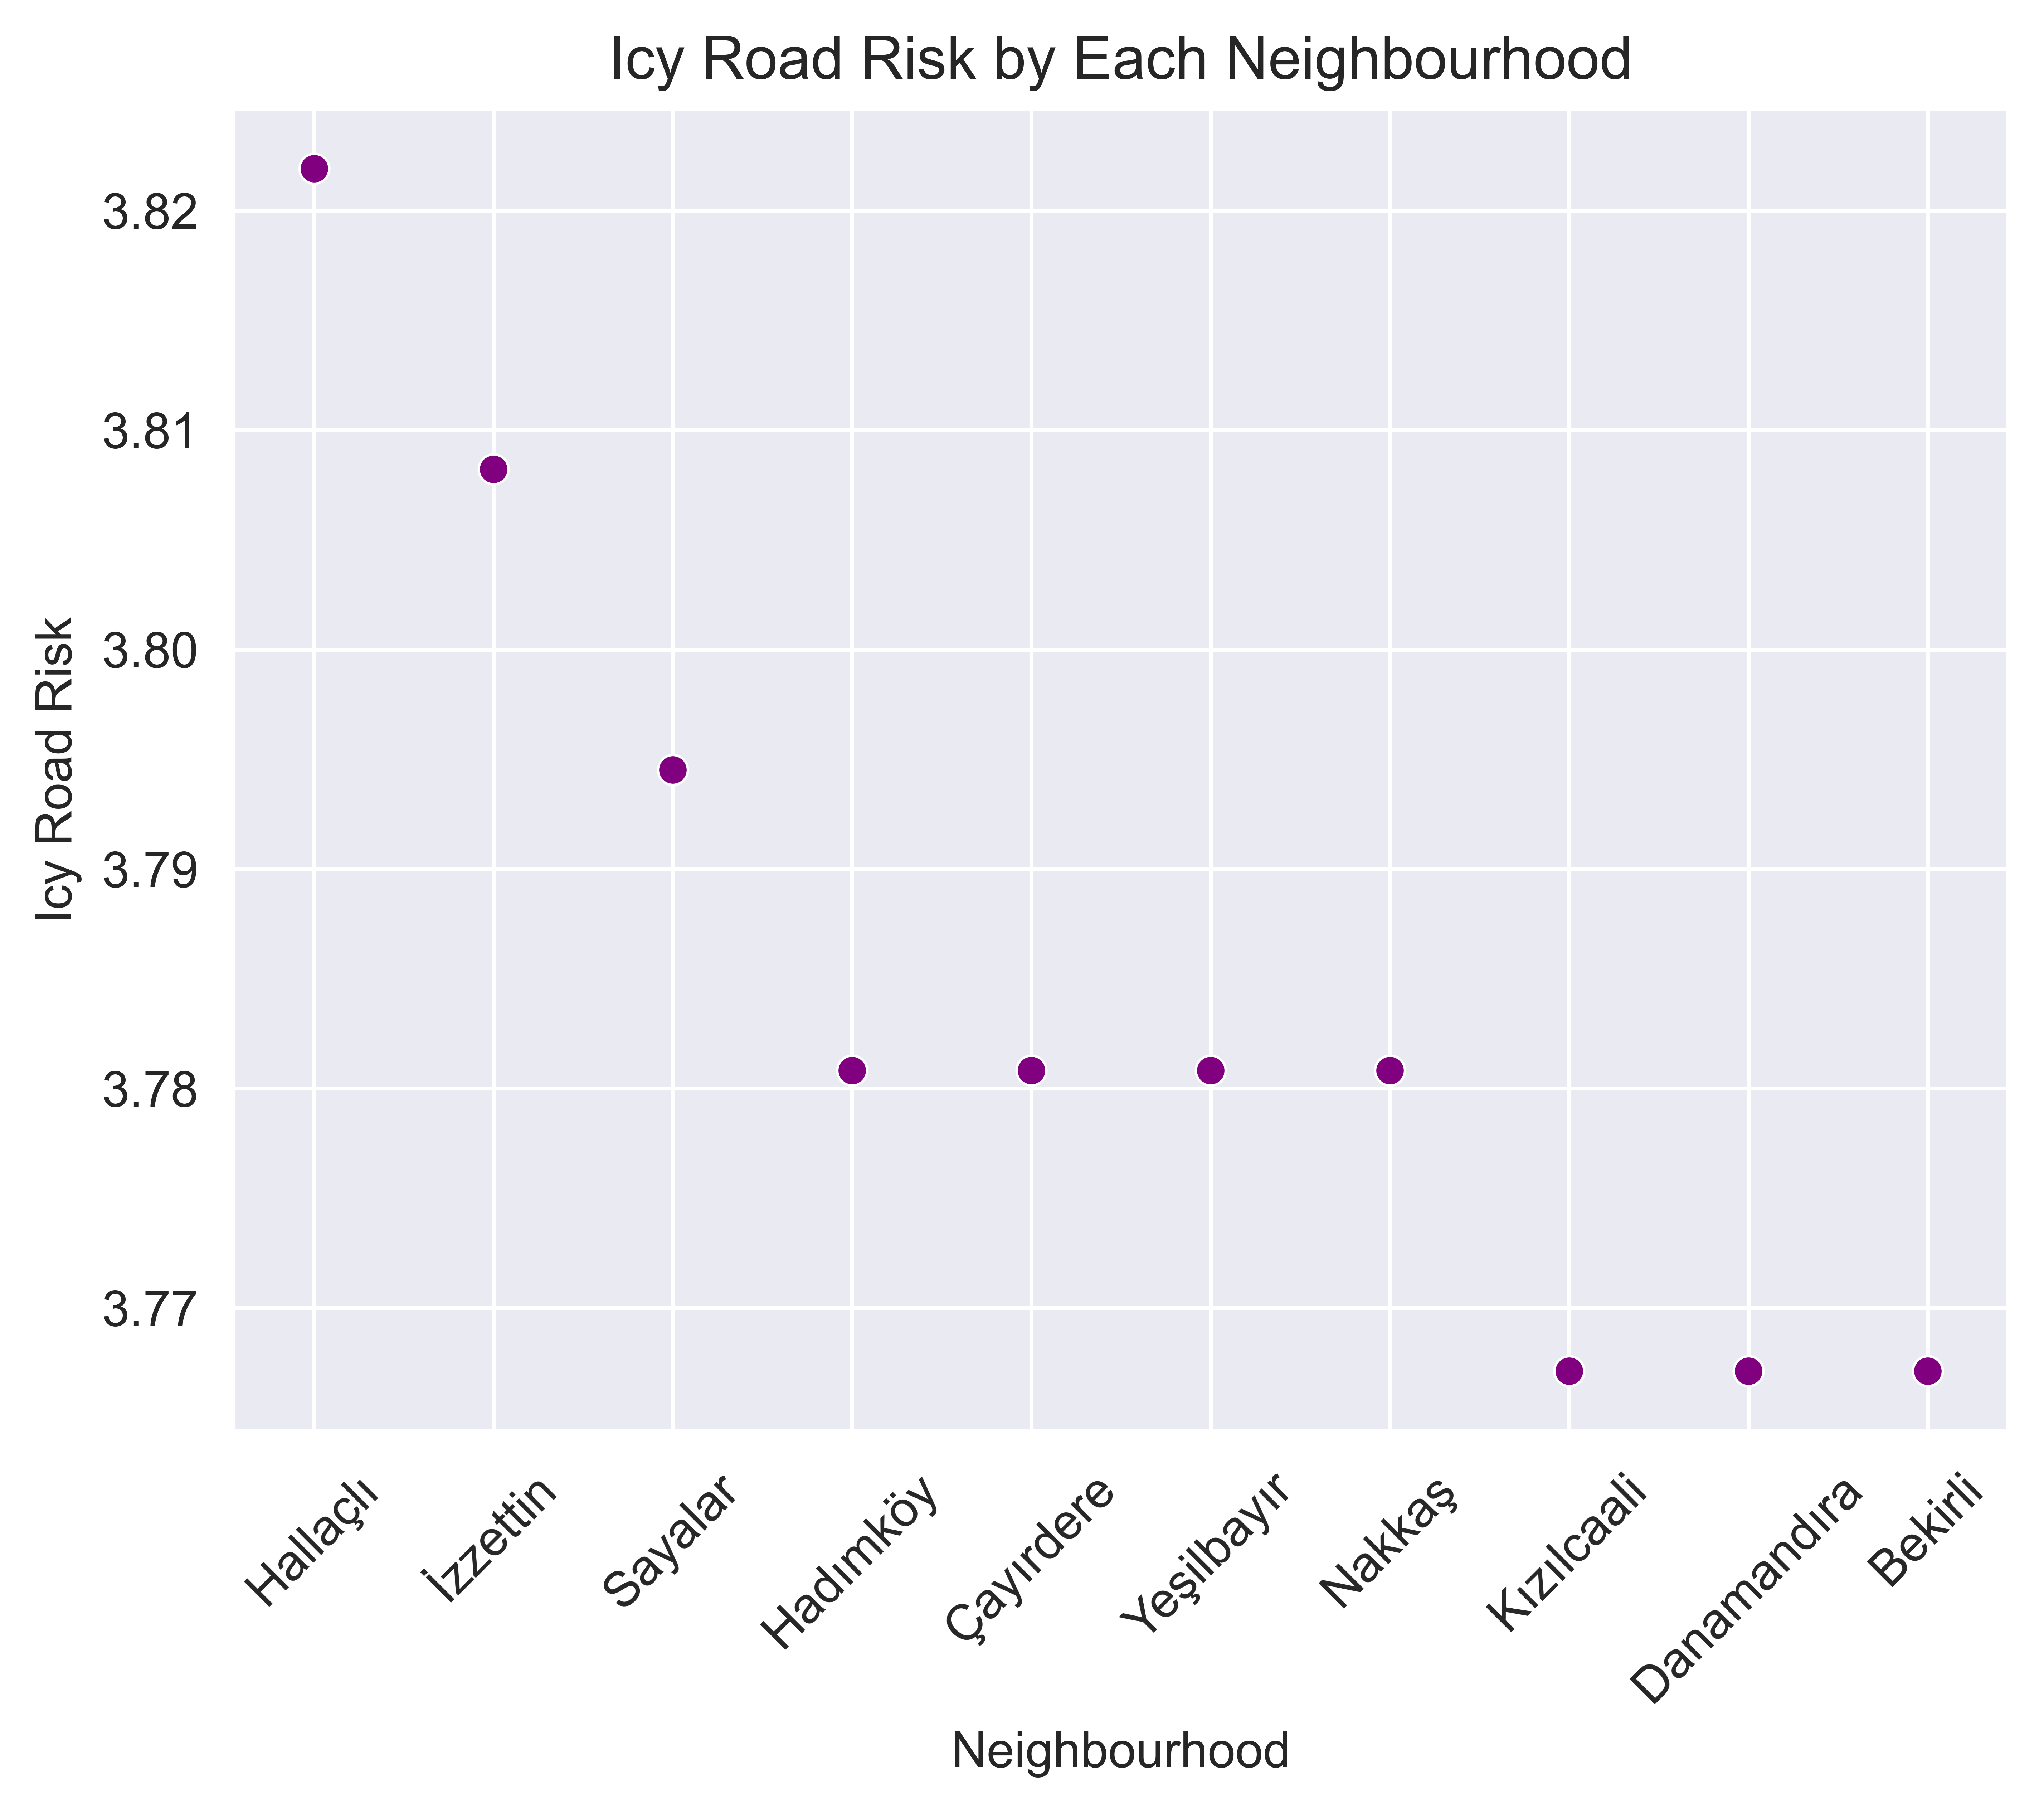

In [17]:
# create desired plots and maps
create_riskplot('ilce', 'Yagis_Risk')
create_riskplot('ilce', 'Ruzgar_Risk')
create_riskplot('ilce', 'Buzlanma_Risk')

create_riskplot('Mahalle', 'Yagis_Risk')
create_riskplot('Mahalle', 'Ruzgar_Risk')
create_riskplot('Mahalle', 'Buzlanma_Risk')

#create_riskmap('ilce', 'Buzlanma_Risk') ---> Should be executed inside an IDE
#create_riskmap('ilce', 'Yagis_Risk')
#create_riskmap('ilce', 'Ruzgar_Risk')